# Midterm

Paper: PMID 27667667
Data link (available in paper): https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-5061

From E-MTAB-5061.idf.txt:
Format of the datafile ‘pancreas_refseq_rpkms_counts_3514sc.txt’: The file contains both the normalized rpkm values and the raw read counts for each sample. Columns correspond to samples and rows to genes. The first line of the file (starting with: #samples) contains the sample IDs to be used as column labels for both the rpkm and counts. The columns of the rpkm and the counts have the same order with the sample IDs. Columns 1:3514 correspond to rpkm values, Columns 3515:7028 correspond to read counts. Rows 1:26179 correspond to data for RefSeq genes, Rows 26180:26271 correspond to data for the 92 external RNA spike-in controls (ERCCs), Row 26272 (last) contains data for ‘eGFP’.

In [2]:
library(dplyr)
library(Seurat)
library(patchwork)
options(repr.plot.width=16, repr.plot.height=8)

## Segerstolpe dataset

### Getting data

In [3]:
cell.barcodes <- scan(text = readLines("../data/E-MTAB-5061/pancreas_refseq_rpkms_counts_3514sc.txt", 1), 
                      what = "", quiet = TRUE)[-1] # 3514 cell barcodes
head(cell.barcodes)

[1] "HP1502401_N13" "HP1502401_D14" "HP1502401_F14" "HP1502401_J13"
[5] "HP1502401_B13" "HP1502401_H13"

In [4]:
count = read.table('../data/E-MTAB-5061/pancreas_refseq_rpkms_counts_3514sc.txt',sep='\t')
head(count)

V1      V2                                  V3 V4 V5 V6 V7 V8        V9
1 SGIP1   NM_032291                           0  0  0  0  0    0.00000 0 
2 AZIN2   NM_052998+NM_001293562              0  0  0  0  0   41.51929 0 
3 CLIC4   NM_013943                           0  0  0  0  0    0.00000 0 
4 AGBL4   NM_032785                           0  0  0  0  0    0.00000 0 
5 NECAP2  NM_001145277+NM_001145278+NM_018090 0  0  0  0  0   13.99272 0 
6 SLC45A1 NM_001080397                        0  0  0  0  0  149.80023 0 
  V10      ⋯ V7021 V7022 V7023 V7024 V7025 V7026 V7027 V7028 V7029 V7030
1  0.00000 ⋯ 0      0     0     7    0     4      0    0     0     0    
2  0.00000 ⋯ 0      0     0    16    0     0      0    0     0     4    
3  0.00000 ⋯ 2     20    64    18    0     0      0    0     0     1    
4  0.00000 ⋯ 0      0     0     0    0     0      5    0     0     0    
5 18.92435 ⋯ 0      0     0    14    0     1     47    7     0     6    
6 78.07885 ⋯ 0      0     0     0    0     0      1    0     0     1

In [5]:
gene.meta=count[,1:2] # First two columns are gene symbols and IDs
head(gene.meta)

V1      V2                                 
1 SGIP1   NM_032291                          
2 AZIN2   NM_052998+NM_001293562             
3 CLIC4   NM_013943                          
4 AGBL4   NM_032785                          
5 NECAP2  NM_001145277+NM_001145278+NM_018090
6 SLC45A1 NM_001080397

Remove metadata from the `count`.

In [6]:
count=count[,-(1:2)]
head(count)

V3 V4 V5 V6 V7 V8        V9 V10      V11       V12       ⋯ V7021 V7022 V7023
1 0  0  0  0  0    0.00000 0   0.00000  0.000000 0.0000000 ⋯ 0      0     0   
2 0  0  0  0  0   41.51929 0   0.00000  0.000000 0.0000000 ⋯ 0      0     0   
3 0  0  0  0  0    0.00000 0   0.00000  5.463685 0.2308227 ⋯ 2     20    64   
4 0  0  0  0  0    0.00000 0   0.00000  0.000000 0.0000000 ⋯ 0      0     0   
5 0  0  0  0  0   13.99272 0  18.92435 44.923718 0.0000000 ⋯ 0      0     0   
6 0  0  0  0  0  149.80023 0  78.07885  0.000000 0.0000000 ⋯ 0      0     0   
  V7024 V7025 V7026 V7027 V7028 V7029 V7030
1  7    0     4      0    0     0     0    
2 16    0     0      0    0     0     4    
3 18    0     0      0    0     0     1    
4  0    0     0      5    0     0     0    
5 14    0     1     47    7     0     6    
6  0    0     0      1    0     0     1

We only care about read counts, not rpkm values.

In [7]:
count=as.matrix(count[,3515:7028]) # Columns 3515:7028 correspond to read counts.
head(count, 3)

V3517 V3518 V3519 V3520 V3521 V3522 V3523 V3524 V3525 V3526 ⋯ V7021 V7022
[1,] 0     0     0     0     0     0     0     0      0    0     ⋯ 0      0   
[2,] 0     0     0     0     0     3     0     0      0    0     ⋯ 0      0   
[3,] 0     0     0     0     0     0     0     0     14    1     ⋯ 2     20   
     V7023 V7024 V7025 V7026 V7027 V7028 V7029 V7030
[1,]  0     7    0     4     0     0     0     0    
[2,]  0    16    0     0     0     0     0     4    
[3,] 64    18    0     0     0     0     0     1

### Labeling rows and columns 

We add column names and row names with genes and samples.

In [8]:
rownames(count)=gene.meta[,1]
colnames(count)=cell.barcodes
head(count)

HP1502401_N13 HP1502401_D14 HP1502401_F14 HP1502401_J13 HP1502401_B13
SGIP1   0             0             0             0             0            
AZIN2   0             0             0             0             0            
CLIC4   0             0             0             0             0            
AGBL4   0             0             0             0             0            
NECAP2  0             0             0             0             0            
SLC45A1 0             0             0             0             0            
        HP1502401_H13 HP1502401_J14 HP1502401_B14 HP1502401_A14 HP1502401_C14 ⋯
SGIP1    0            0              0             0            0             ⋯
AZIN2    3            0              0             0            0             ⋯
CLIC4    0            0              0            14            1             ⋯
AGBL4    0            0              0             0            0             ⋯
NECAP2   1            0             10            53            0             ⋯
SLC45A1 13            0             52             0            0             ⋯
        HP1525301T2D_O10 HP1526901T2D_H2 HP1526901T2D_I16 HP1526901T2D_F7
SGIP1   0                 0               0                7             
AZIN2   0                 0               0               16             
CLIC4   2                20              64               18             
AGBL4   0                 0               0                0             
NECAP2  0                 0               0               14             
SLC45A1 0                 0               0                0             
        HP1526901T2D_I23 HP1525301T2D_K3 HP1525301T2D_J10 HP1526901T2D_N8
SGIP1   0                4                0               0              
AZIN2   0                0                0               0              
CLIC4   0                0                0               0              
AGBL4   0                0                5               0              
NECAP2  0                1               47               7              
SLC45A1 0                0                1               0              
        HP1526901T2D_O11 HP1526901T2D_A8
SGIP1   0                0              
AZIN2   0                4              
CLIC4   0                1              
AGBL4   0                0              
NECAP2  0                6              
SLC45A1 0                1

In [9]:
rm(gene.meta, cell.barcodes)

In [10]:
dim(t(count))

[1]  3514 26271

### Ordering cells to match `cell.meta`

In [11]:
cell.meta = read.csv('../data/E-MTAB-5061/E-MTAB-5061.sdrf.txt',sep='\t')
head(cell.meta)

Source.Name Characteristics..organism. Characteristics..individual.
1 AZ_A1       Homo sapiens               H1                          
2 AZ_A3       Homo sapiens               H1                          
3 AZ_A4       Homo sapiens               H1                          
4 AZ_B6       Homo sapiens               H1                          
5 AZ_B7       Homo sapiens               H1                          
6 AZ_C12      Homo sapiens               H1                          
  Characteristics..sex. Characteristics..age. Unit..time.unit.
1 male                  43                    year            
2 male                  43                    year            
3 male                  43                    year            
4 male                  43                    year            
5 male                  43                    year            
6 male                  43                    year            
  Characteristics..body.mass.index. Characteristics..organism.status.
1 30.8                              post-mortem                      
2 30.8                              post-mortem                      
3 30.8                              post-mortem                      
4 30.8                              post-mortem                      
5 30.8                              post-mortem                      
6 30.8                              post-mortem                      
  Characteristics..clinical.information. Characteristics..organism.part. ⋯
1 HbA1c 5.0%                             pancreas                        ⋯
2 HbA1c 5.0%                             pancreas                        ⋯
3 HbA1c 5.0%                             pancreas                        ⋯
4 HbA1c 5.0%                             pancreas                        ⋯
5 HbA1c 5.0%                             pancreas                        ⋯
6 HbA1c 5.0%                             pancreas                        ⋯
  Comment.ENA_EXPERIMENT. Scan.Name       Comment.SUBMITTED_FILE_NAME.
1 ERX1700346              AZ_A1.fastq.gz  AZ_A1.fastq.gz              
2 ERX1700351              AZ_A3.fastq.gz  AZ_A3.fastq.gz              
3 ERX1700352              AZ_A4.fastq.gz  AZ_A4.fastq.gz              
4 ERX1700366              AZ_B6.fastq.gz  AZ_B6.fastq.gz              
5 ERX1700367              AZ_B7.fastq.gz  AZ_B7.fastq.gz              
6 ERX1700373              AZ_C12.fastq.gz AZ_C12.fastq.gz             
  Comment.ENA_RUN.
1 ERR1630013      
2 ERR1630018      
3 ERR1630019      
4 ERR1630033      
5 ERR1630034      
6 ERR1630040      
  Comment.FASTQ_URI.                                                          
1 ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/003/ERR1630013/ERR1630013.fastq.gz
2 ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/008/ERR1630018/ERR1630018.fastq.gz
3 ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/009/ERR1630019/ERR1630019.fastq.gz
4 ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/003/ERR1630033/ERR1630033.fastq.gz
5 ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/004/ERR1630034/ERR1630034.fastq.gz
6 ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/000/ERR1630040/ERR1630040.fastq.gz
  Protocol.REF.3 Derived.Array.Data.File                
1 P-MTAB-51966   pancreas_refseq_rpkms_counts_3514sc.txt
2 P-MTAB-51966   pancreas_refseq_rpkms_counts_3514sc.txt
3 P-MTAB-51966   pancreas_refseq_rpkms_counts_3514sc.txt
4 P-MTAB-51966   pancreas_refseq_rpkms_counts_3514sc.txt
5 P-MTAB-51966   pancreas_refseq_rpkms_counts_3514sc.txt
6 P-MTAB-51966   pancreas_refseq_rpkms_counts_3514sc.txt
  Comment..Derived.ArrayExpress.FTP.file.                                                                  
1 ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-5061/E-MTAB-5061.processed.1.zip
2 ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-5061/E-MTAB-5061.processed.1.zip
3 ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-5061/E-MTAB-5061.processed.1.zip
4 ftp://ftp.ebi.ac.uk/pub/databases/microa

In [12]:
table(cell.meta$Characteristics..individual.) # Six healthy individuals, four T2D patients


  H1   H2   H3   H4   H5   H6 T2D1 T2D2 T2D3 T2D4 
  96  352  383  383  383  383  383  383  384  384 

In [13]:
cell.meta=cell.meta[,1:5] # Remove unnecessary meta info for the cells
head(cell.meta)

Source.Name Characteristics..organism. Characteristics..individual.
1 AZ_A1       Homo sapiens               H1                          
2 AZ_A3       Homo sapiens               H1                          
3 AZ_A4       Homo sapiens               H1                          
4 AZ_B6       Homo sapiens               H1                          
5 AZ_B7       Homo sapiens               H1                          
6 AZ_C12      Homo sapiens               H1                          
  Characteristics..sex. Characteristics..age.
1 male                  43                   
2 male                  43                   
3 male                  43                   
4 male                  43                   
5 male                  43                   
6 male                  43

In [14]:
df = t(count)
df = df[cell.meta$Source.Name,]
head(df)

SGIP1 AZIN2 CLIC4 AGBL4 NECAP2 SLC45A1 TGFBR3 DBT RFWD2 C1orf21 ⋯
AZ_A1  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_A3  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_A4  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_B6  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_B7  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_C12 0     0     0     0     0      0       0      0   0     0       ⋯
       ERCC_1.83105469:mix1_3.66210938:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.91552734:mix1_1.83105469:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  1                                   
AZ_C12 0                                   
       ERCC_0.91552734:mix1_1.83105469:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.45776367:mix1_0.91552734:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.22888184:mix1_0.45776367:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.22888184:mix1_0.45776367:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.11444092:mix1_0.22888184:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.05722046:mix1_0.11444092:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.01430512:mix1_0.02861023:mix2 eGFP
AZ_A1  0                                    0   
AZ_A3  0                                    1   
AZ_A4  0                                    0   
AZ_B6  0                                    1   
AZ_B7  0                                    0   
AZ_C12 0                                    0

In [15]:
sum(cell.meta$Source.Name == rownames(df))

[1] 3514

In [16]:
dim(cell.meta)

[1] 3514    5

### Choosing only healthy individuals

Let's find some `Source.Name` that match healthy individuals:

In [17]:
head(cell.meta)

Source.Name Characteristics..organism. Characteristics..individual.
1 AZ_A1       Homo sapiens               H1                          
2 AZ_A3       Homo sapiens               H1                          
3 AZ_A4       Homo sapiens               H1                          
4 AZ_B6       Homo sapiens               H1                          
5 AZ_B7       Homo sapiens               H1                          
6 AZ_C12      Homo sapiens               H1                          
  Characteristics..sex. Characteristics..age.
1 male                  43                   
2 male                  43                   
3 male                  43                   
4 male                  43                   
5 male                  43                   
6 male                  43

In [18]:
healthy_cell.meta <- cell.meta %>%
    filter(Characteristics..individual. == c('H1') | 
           Characteristics..individual. == c('H2') | 
           Characteristics..individual. == c('H3') | 
           Characteristics..individual. == c('H4') | 
           Characteristics..individual. == c('H5') | 
           Characteristics..individual. == c('H6'))

In [19]:
head(healthy_cell.meta)

Source.Name Characteristics..organism. Characteristics..individual.
1 AZ_A1       Homo sapiens               H1                          
2 AZ_A3       Homo sapiens               H1                          
3 AZ_A4       Homo sapiens               H1                          
4 AZ_B6       Homo sapiens               H1                          
5 AZ_B7       Homo sapiens               H1                          
6 AZ_C12      Homo sapiens               H1                          
  Characteristics..sex. Characteristics..age.
1 male                  43                   
2 male                  43                   
3 male                  43                   
4 male                  43                   
5 male                  43                   
6 male                  43

Now we only choose cells from healthy individuals.

In [20]:
table(cell.meta$Characteristics..individual.)


  H1   H2   H3   H4   H5   H6 T2D1 T2D2 T2D3 T2D4 
  96  352  383  383  383  383  383  383  384  384 

In [21]:
96+352+383+383+383+383

[1] 1980

Looking at the table, we know there should be 1980 individuals.

In [22]:
df = df[healthy_cell.meta$Source.Name,]
dim(df)

[1]  1980 26271

### Quality control

Let's follow steps on [Seurat - Guided Clustering Tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html).

In [23]:
head(df)

SGIP1 AZIN2 CLIC4 AGBL4 NECAP2 SLC45A1 TGFBR3 DBT RFWD2 C1orf21 ⋯
AZ_A1  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_A3  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_A4  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_B6  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_B7  0     0     0     0     0      0       0      0   0     0       ⋯
AZ_C12 0     0     0     0     0      0       0      0   0     0       ⋯
       ERCC_1.83105469:mix1_3.66210938:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.91552734:mix1_1.83105469:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  1                                   
AZ_C12 0                                   
       ERCC_0.91552734:mix1_1.83105469:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.45776367:mix1_0.91552734:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.22888184:mix1_0.45776367:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.22888184:mix1_0.45776367:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.11444092:mix1_0.22888184:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.05722046:mix1_0.11444092:mix2
AZ_A1  0                                   
AZ_A3  0                                   
AZ_A4  0                                   
AZ_B6  0                                   
AZ_B7  0                                   
AZ_C12 0                                   
       ERCC_0.01430512:mix1_0.02861023:mix2 eGFP
AZ_A1  0                                    0   
AZ_A3  0                                    1   
AZ_A4  0                                    0   
AZ_B6  0                                    1   
AZ_B7  0                                    0   
AZ_C12 0                                    0

Remove duplicated genes.

In [24]:
sum(duplicated(rownames(df)))

[1] 0

In [25]:
sum(duplicated(colnames(df)))

[1] 745

In [26]:
df = df[, !duplicated(colnames(df))]
sum(duplicated(colnames(df)))

[1] 0

In [27]:
dim(df)

[1]  1980 25526

We transpose our transpose to create a seurat object because Seurat object wants cells on columns and gens on rows.

In [28]:
seger <- CreateSeuratObject(counts = t(df), project = "seger", min.cells = 3, min.features = 200)
seger

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”


An object of class Seurat 
20029 features across 1841 samples within 1 assay 
Active assay: RNA (20029 features, 0 variable features)
 1 layer present: counts

For Quality control, we want to look at the following:

- The number of unique genes detected in each cell.
  - Low-quality cells or empty droplets will often have very few genes.
  - Cell doublets or multiplets may exhibit an aberrantly high gene count.
- Similarly, the total number of molecules detected within a cell (correlates strongly with unique genes).
- The percentage of reads that map to the mitochondrial genome
  - Low-quality / dying cells often exhibit extensive mitochondrial contamination.
  - We calculate mitochondrial QC metrics with the `PercentageFeatureSet()` function, which calculates the percentage of counts originating from a set of features.
  - We use the set of all genes starting with MT- as a set of mitochondrial genes.

There is no mitochondrial genes in this data.

In [39]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
seger[["percent.mt"]] <- PercentageFeatureSet(seger, pattern = "^mt-")

In [33]:
sum(PercentageFeatureSet(seger, pattern = "^mt-"))

[1] 0

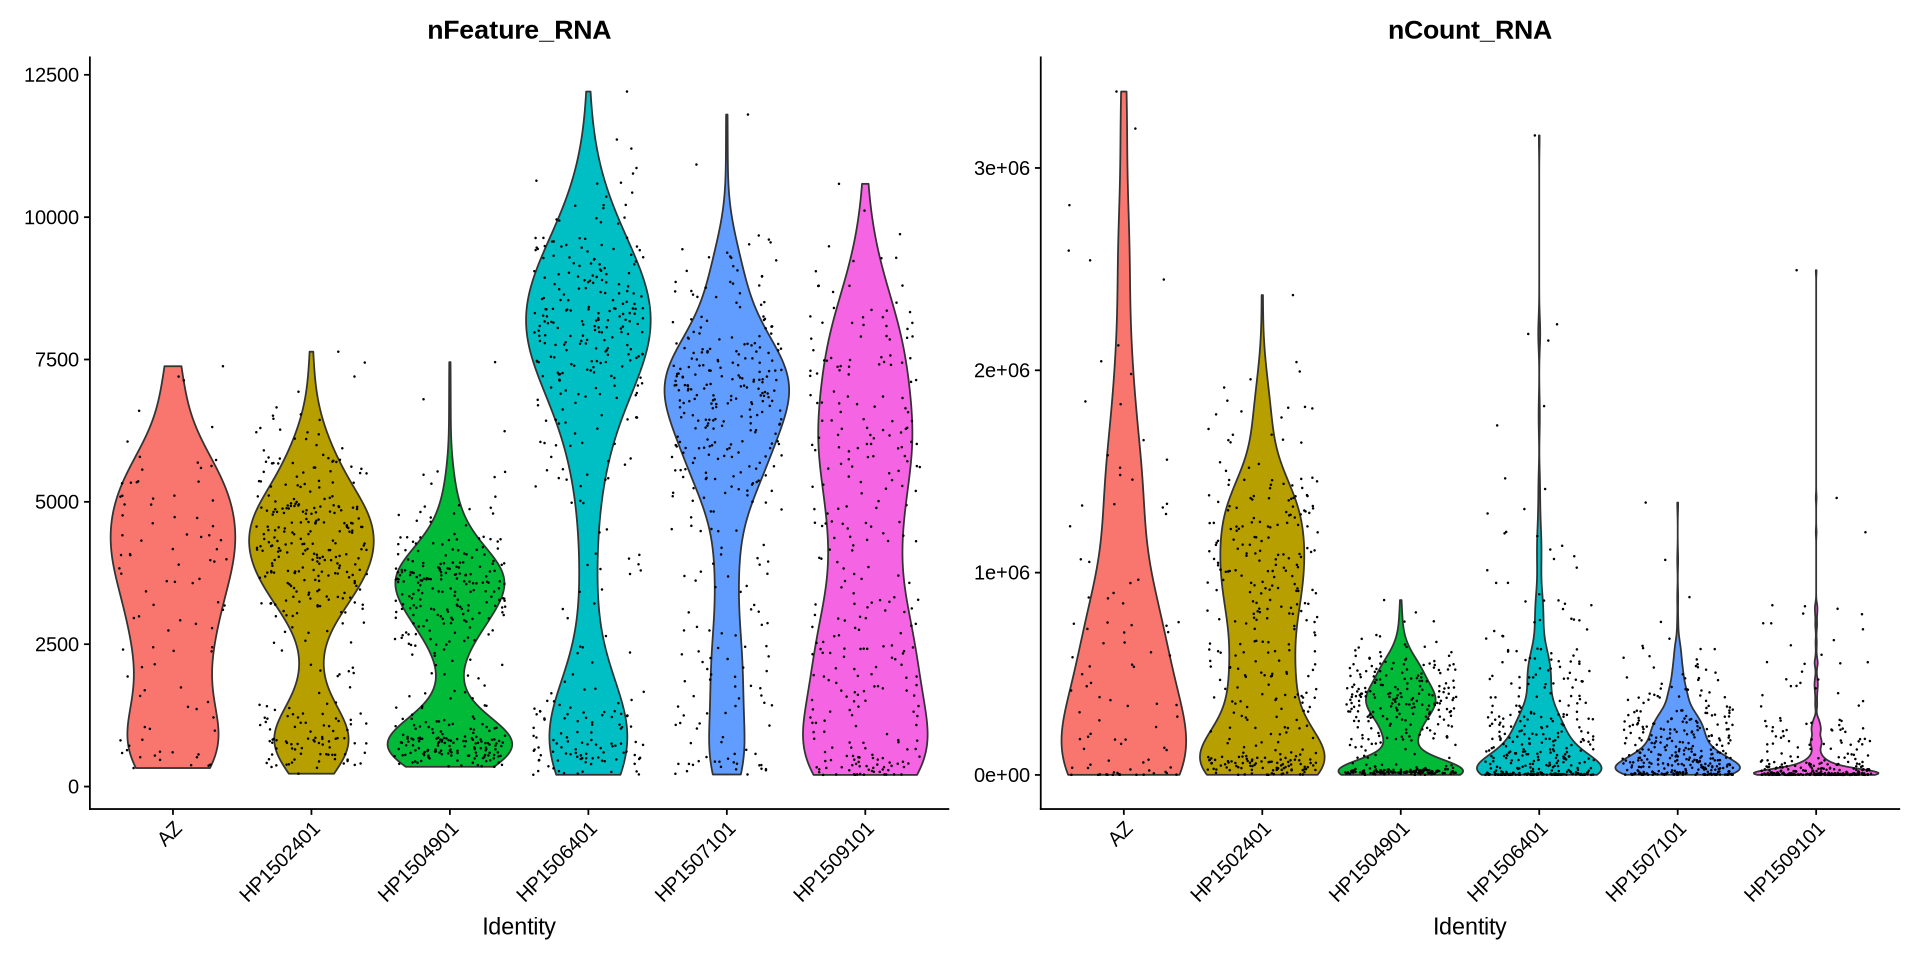

In [40]:
# Visualize QC metrics as a violin plot
VlnPlot(seger, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

Not sure how to remove the warning message.

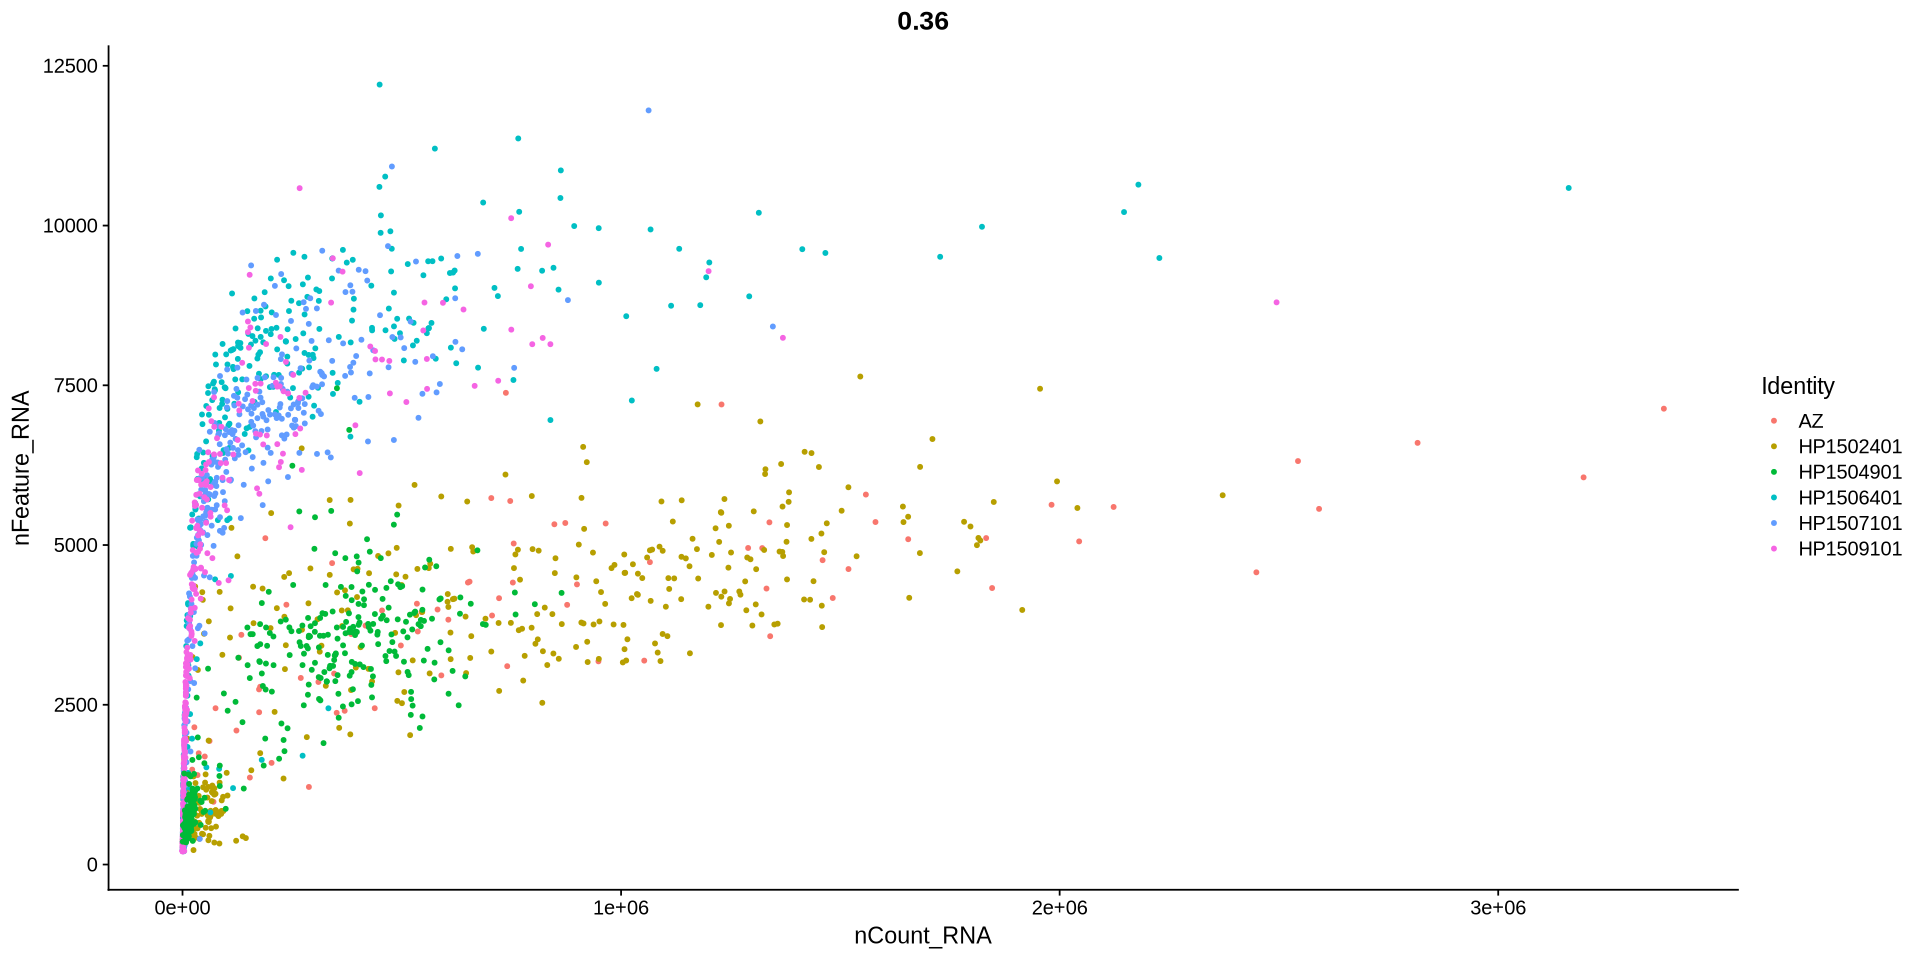

In [37]:
FeatureScatter(seger, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

Removing may not be good yet because of the warning above.

In [31]:
subset(seger, subset = nFeature_RNA > 200 & nFeature_RNA < 2500)

An object of class Seurat 
20029 features across 590 samples within 1 assay 
Active assay: RNA (20029 features, 0 variable features)
 1 layer present: counts

### Normalizing the data

In [38]:
seger <- NormalizeData(seger)
seger

Normalizing layer: counts



An object of class Seurat 
20029 features across 1841 samples within 1 assay 
Active assay: RNA (20029 features, 0 variable features)
 2 layers present: counts, data

### Highly variable features (feature selection)

We only care about genes that vary a lot. We chose top 2000 genes, but we could get away with smaller numbers.

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


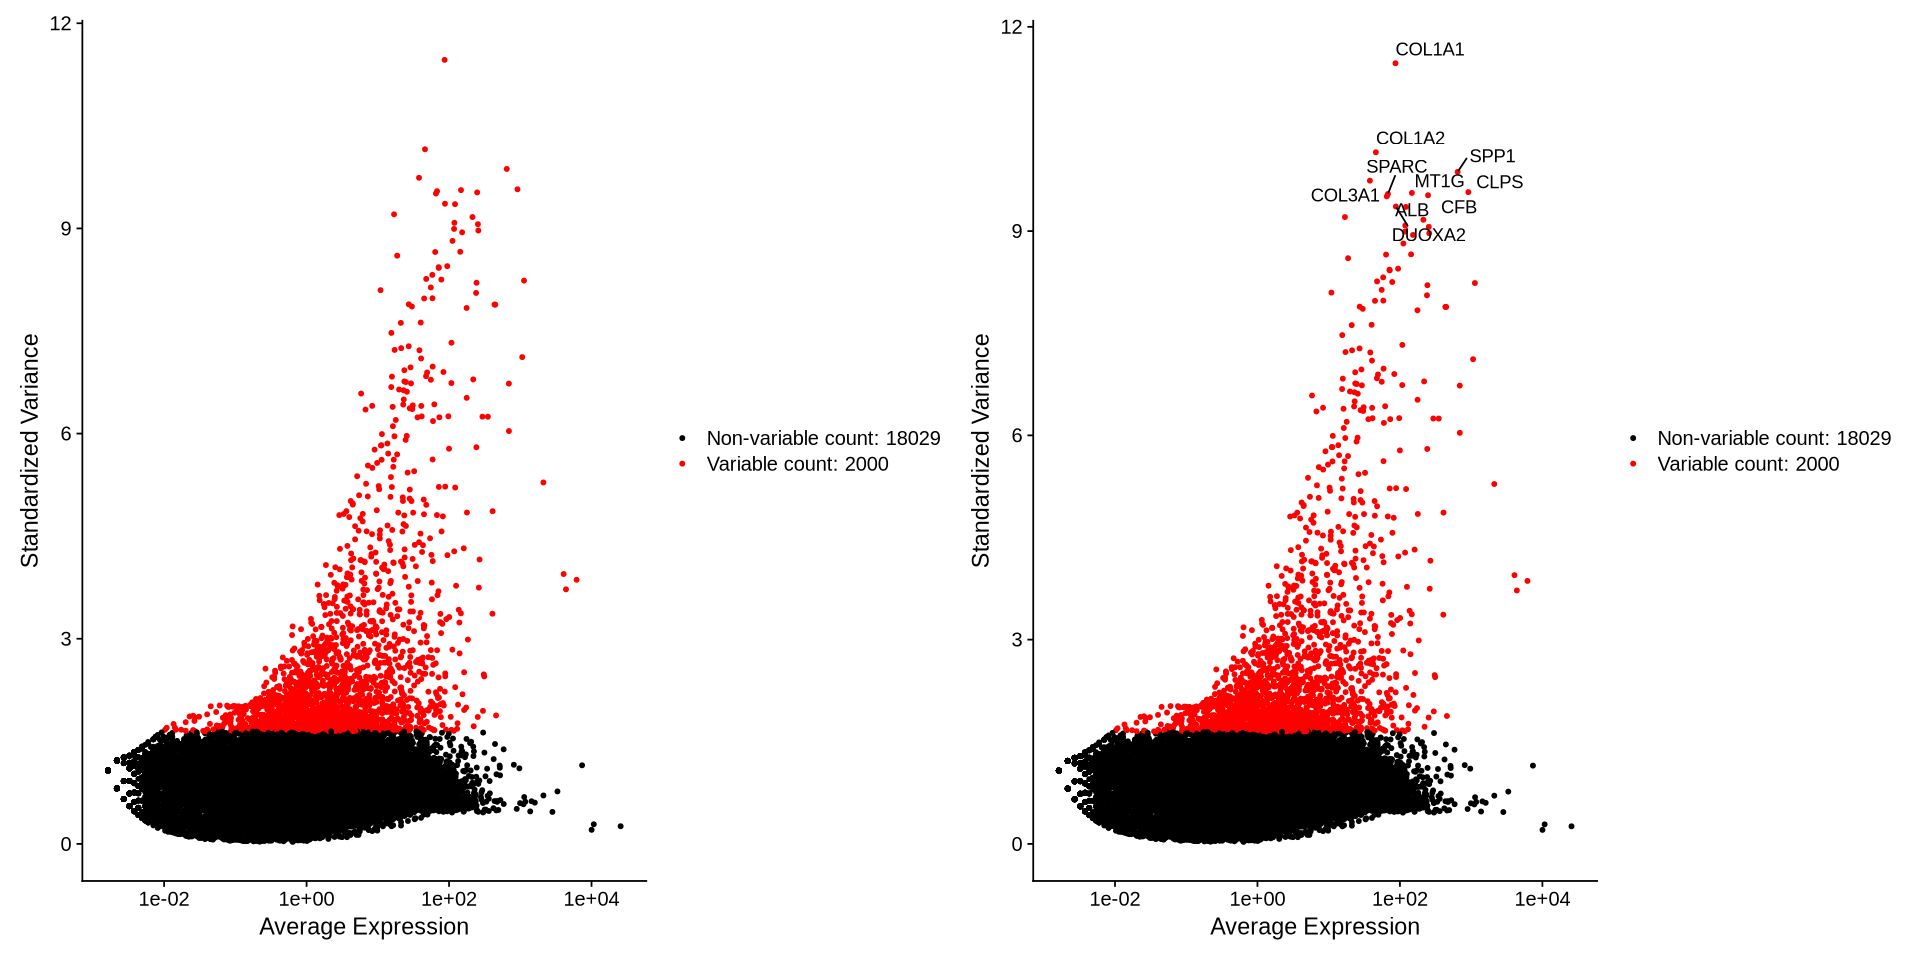

In [42]:
seger <- FindVariableFeatures(seger, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(seger), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(seger)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

### Scaling data

Before applying PCA, we have to scale our data so that mean is 0 and variance is 1 for each gene. By default, `ScaleData` only scales highly variable genes, but we want to scale all the genes. This helps us with visualization later.

In [43]:
all.genes <- rownames(seger)
seger <- ScaleData(seger, features = all.genes)

Centering and scaling data matrix



### PCA

PCA allows us to reduce dimension so we can use clustering.

In [44]:
seger <- RunPCA(seger, features = VariableFeatures(object = seger))
print(seger[['pca']], dims = 1:2, nfeatures = 2)

PC_ 1 
Positive:  IFITM3, SERPING1, CTSH, CDC42EP1, PRSS8, RHOC, DHRS3, KRT7, TACSTD2, ZFP36L1 
	   ANXA4, TMSB4X, CLDN1, CD24, LGALS3, S100A11, LCN2, SDC4, LAD1, LITAF 
	   SERPINA3, KRT18, SERPINA5, IFITM2, CLDN10, CFB, TM4SF1, KRT19, MUC20, RBPMS 
Negative:  G6PC2, CRYBA2, PEMT, HEPACAM2, SCGB2A1, RFX6, PCP4, SLC38A4, RGS4, FAM159B 
	   RGS9, PARM1, LOXL4, CRH, FAM105A, PLCE1, EDIL3, PCSK1, RBP4, FAP 
	   SST, SERPINI1, RASD1, NR0B1, MLLT11, DHRS2, C1QL1, MLIP, SPTSSB, IAPP 
PC_ 2 
Positive:  SPARC, COL4A1, NID1, LRRC32, IFITM1, COL1A2, TIMP3, PXDN, BGN, PDGFRB 
	   COL6A2, COL3A1, LAMA4, COL5A1, COL1A1, COL6A3, F2R, SFRP2, TMEM204, IGFBP4 
	   THY1, PTRF, ENG, AEBP1, CDH11, ANGPTL2, MMP2, LHFP, COL15A1, PLXDC1 
Negative:  CD24, KRT8, LCN2, CLDN4, GATM, ELF3, PRSS8, SERPINA3, TACSTD2, SDC4 
	   CFB, REG1A, KRT7, MUC1, SPINK1, ANPEP, RAB11FIP1, AMBP, GSTA1, CD74 
	   KRT18, ANXA4, SERPINA5, LYZ, LAD1, CLDN1, PRSS1, CD44, ADH1C, GGT6 
PC_ 3 
Positive:  TINAGL1, CFTR, CMTM7, SPP1, CCND

PC_ 1 
Positive:  IFITM3, SERPING1 
Negative:  G6PC2, CRYBA2 
PC_ 2 
Positive:  SPARC, COL4A1 
Negative:  CD24, KRT8 


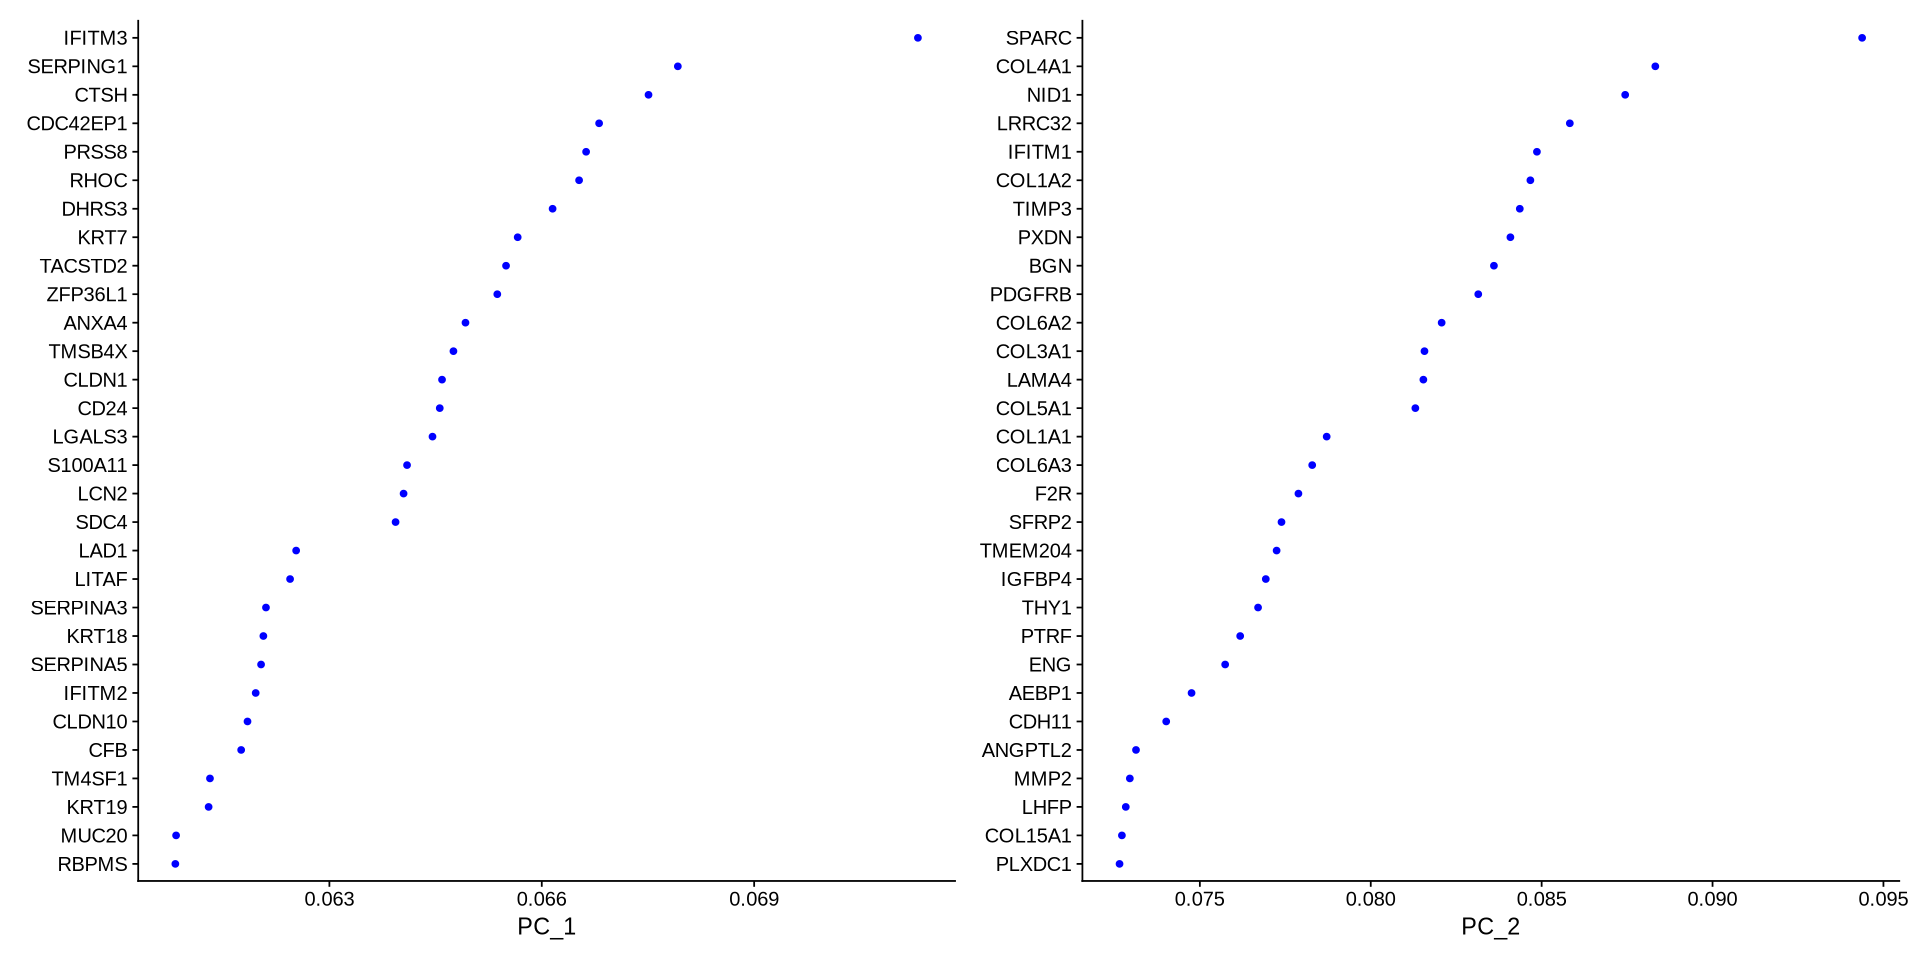

In [45]:
VizDimLoadings(seger, dims = 1:2, reduction = "pca")

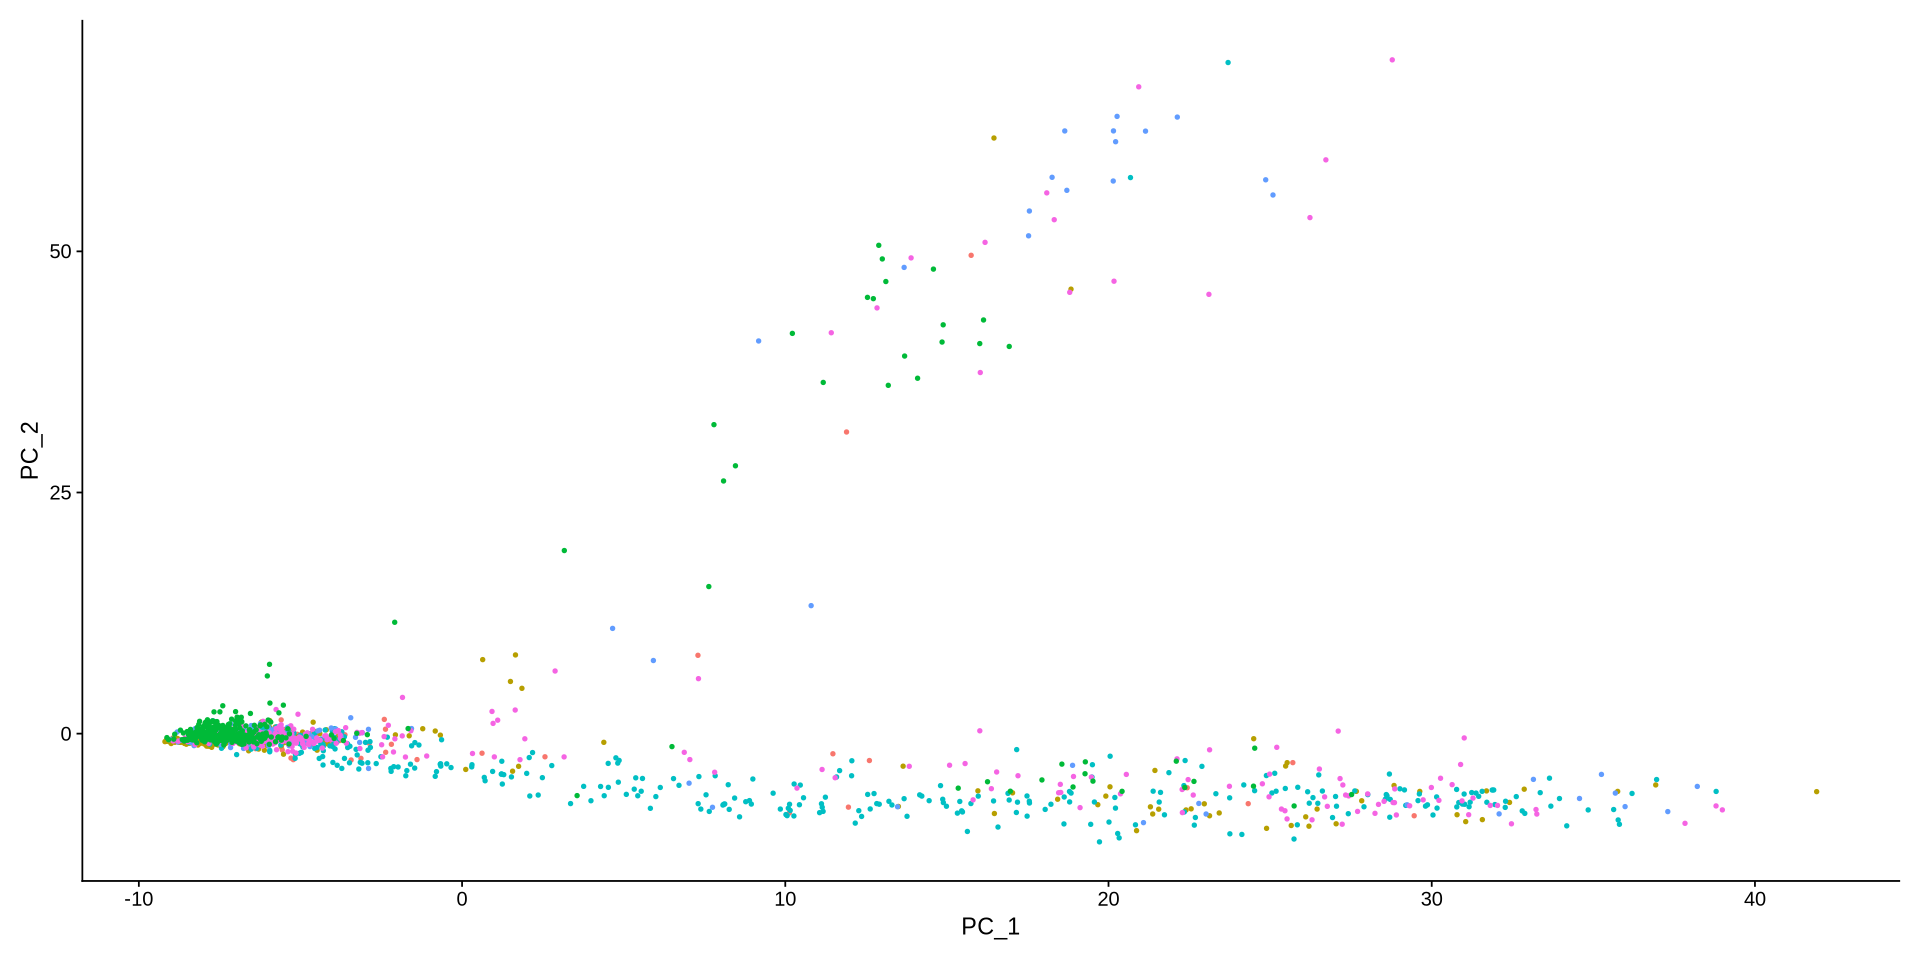

In [46]:
DimPlot(seger, reduction = "pca") + NoLegend()

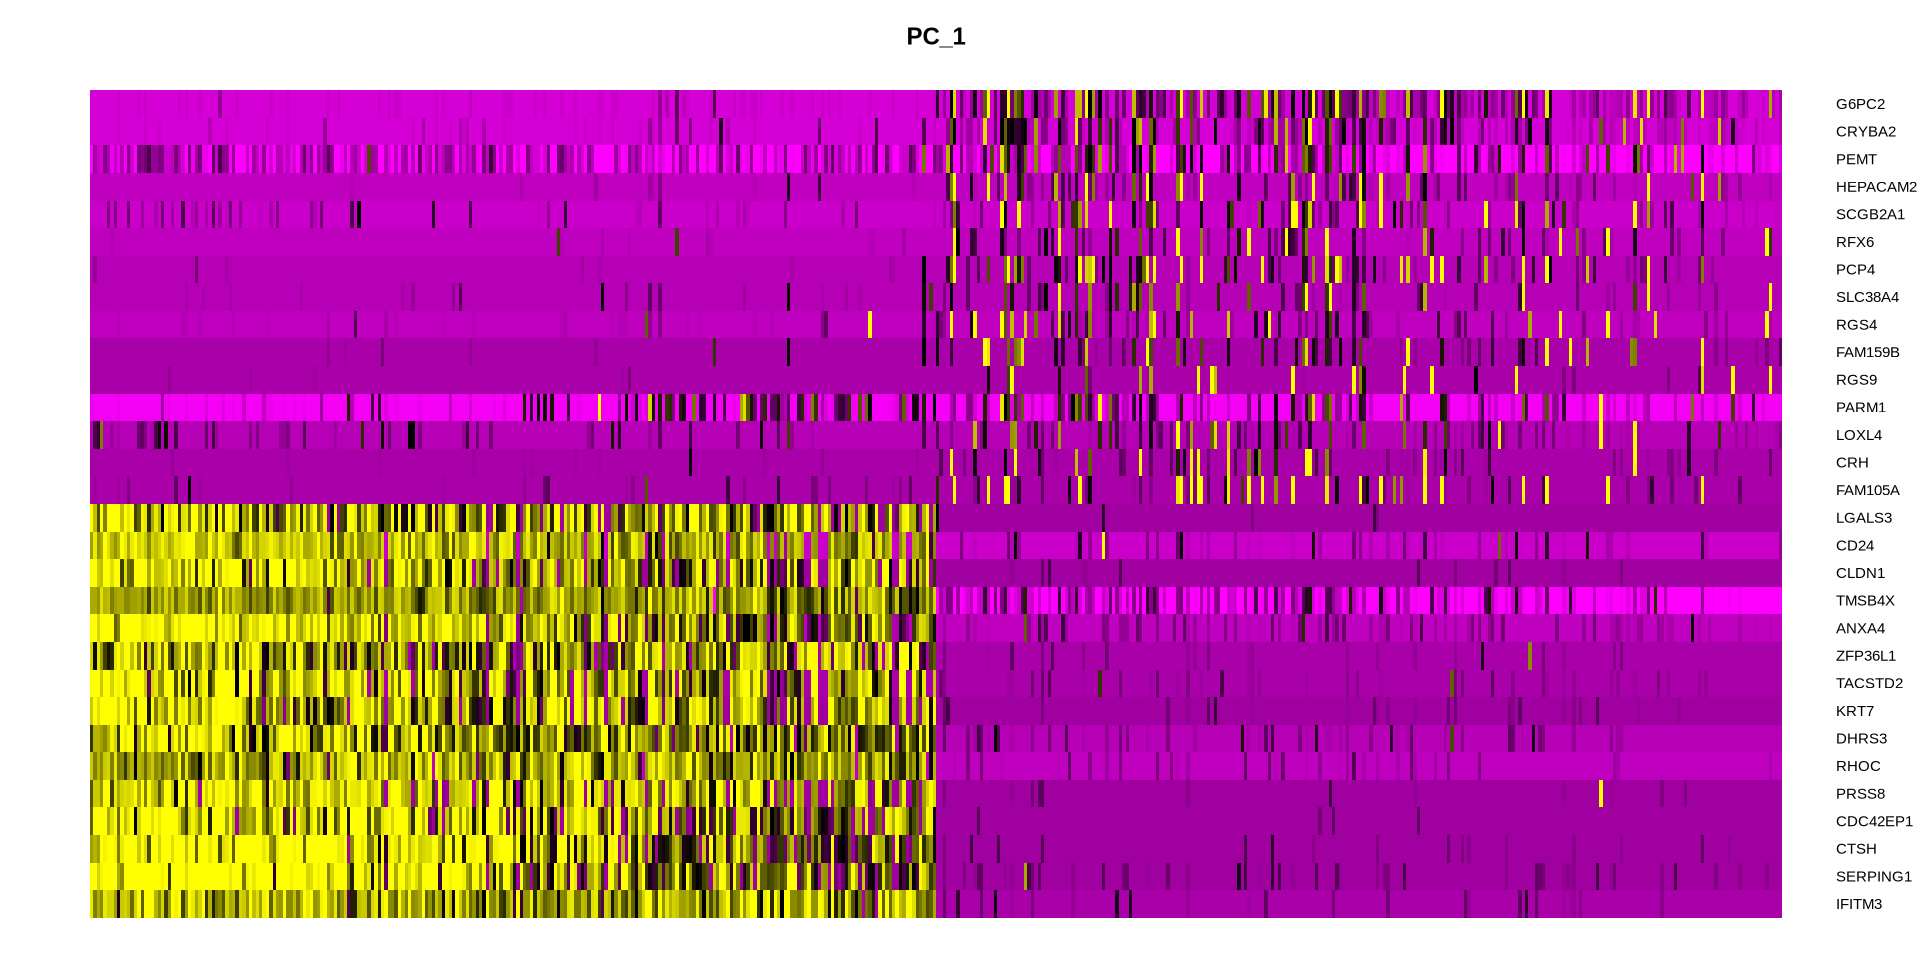

In [47]:
DimHeatmap(seger, dims = 1, cells = 500, balanced = TRUE)

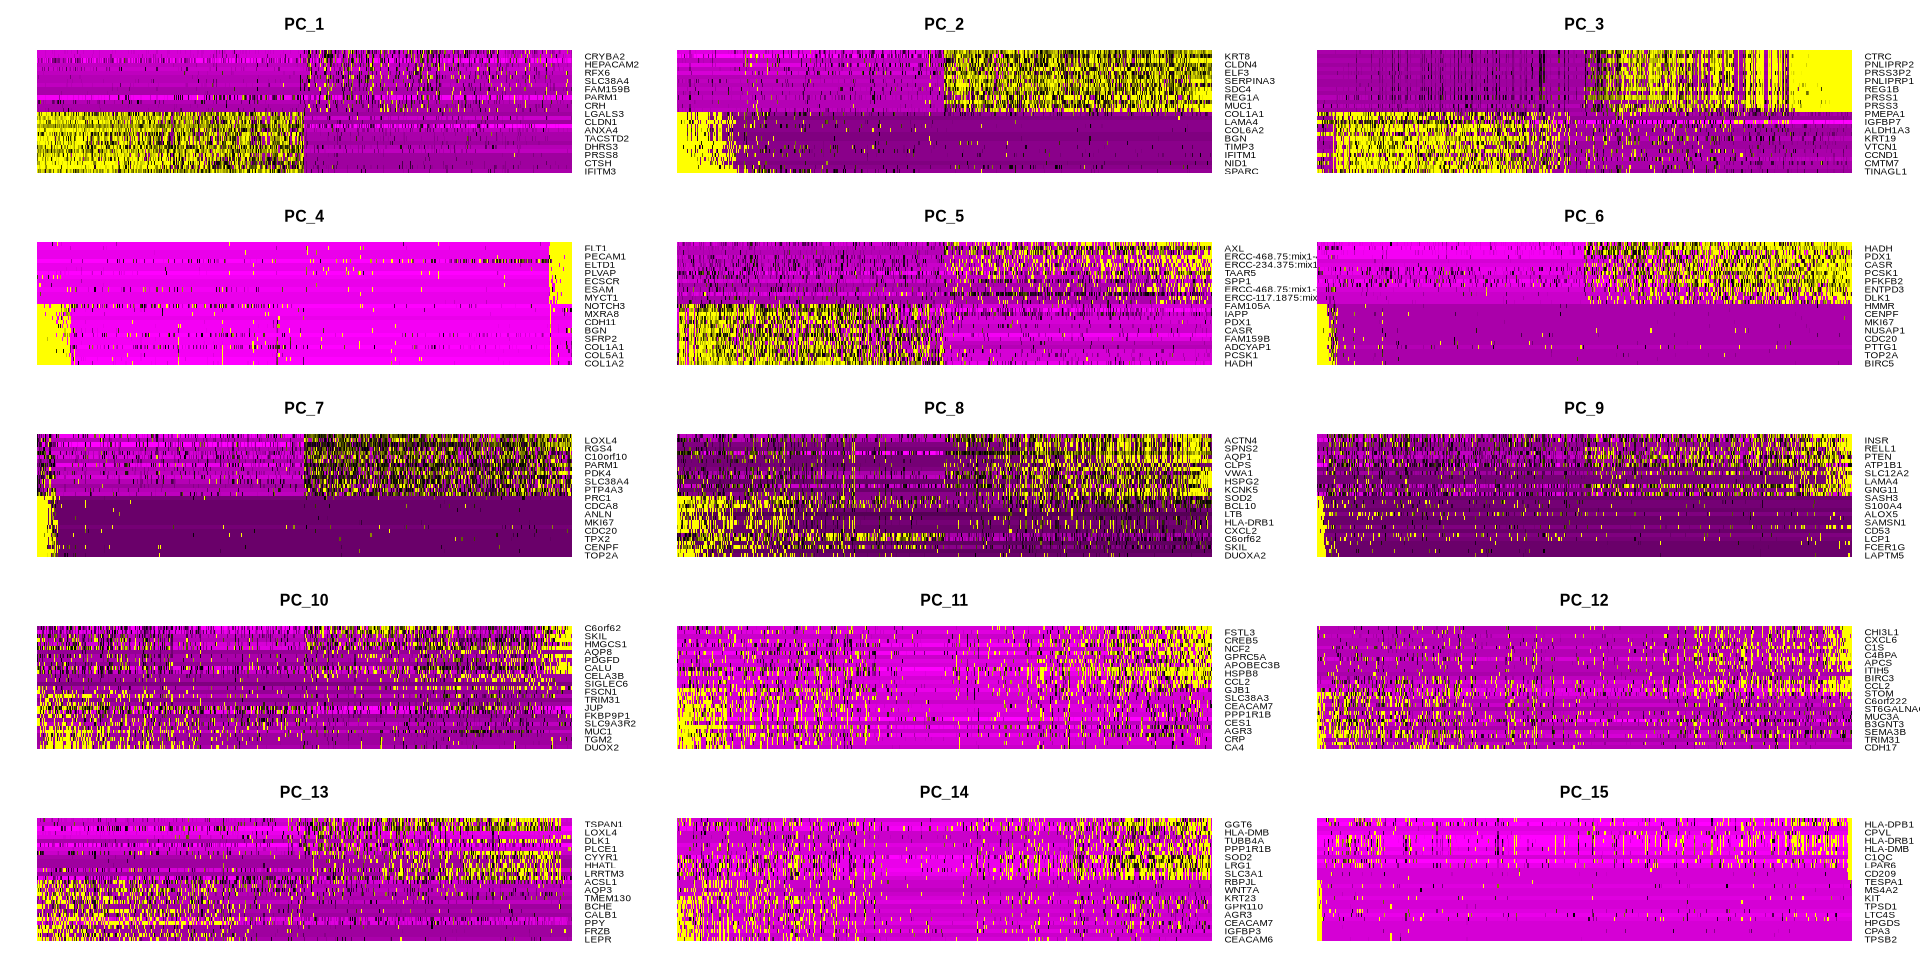

In [48]:
DimHeatmap(seger, dims = 1:15, cells = 500, balanced = TRUE)

### Determining the dimensionality of the dataset

Looking at the Elbowplot, we can choose 10 PCs and it should be good. More PCs will just give us more noise.

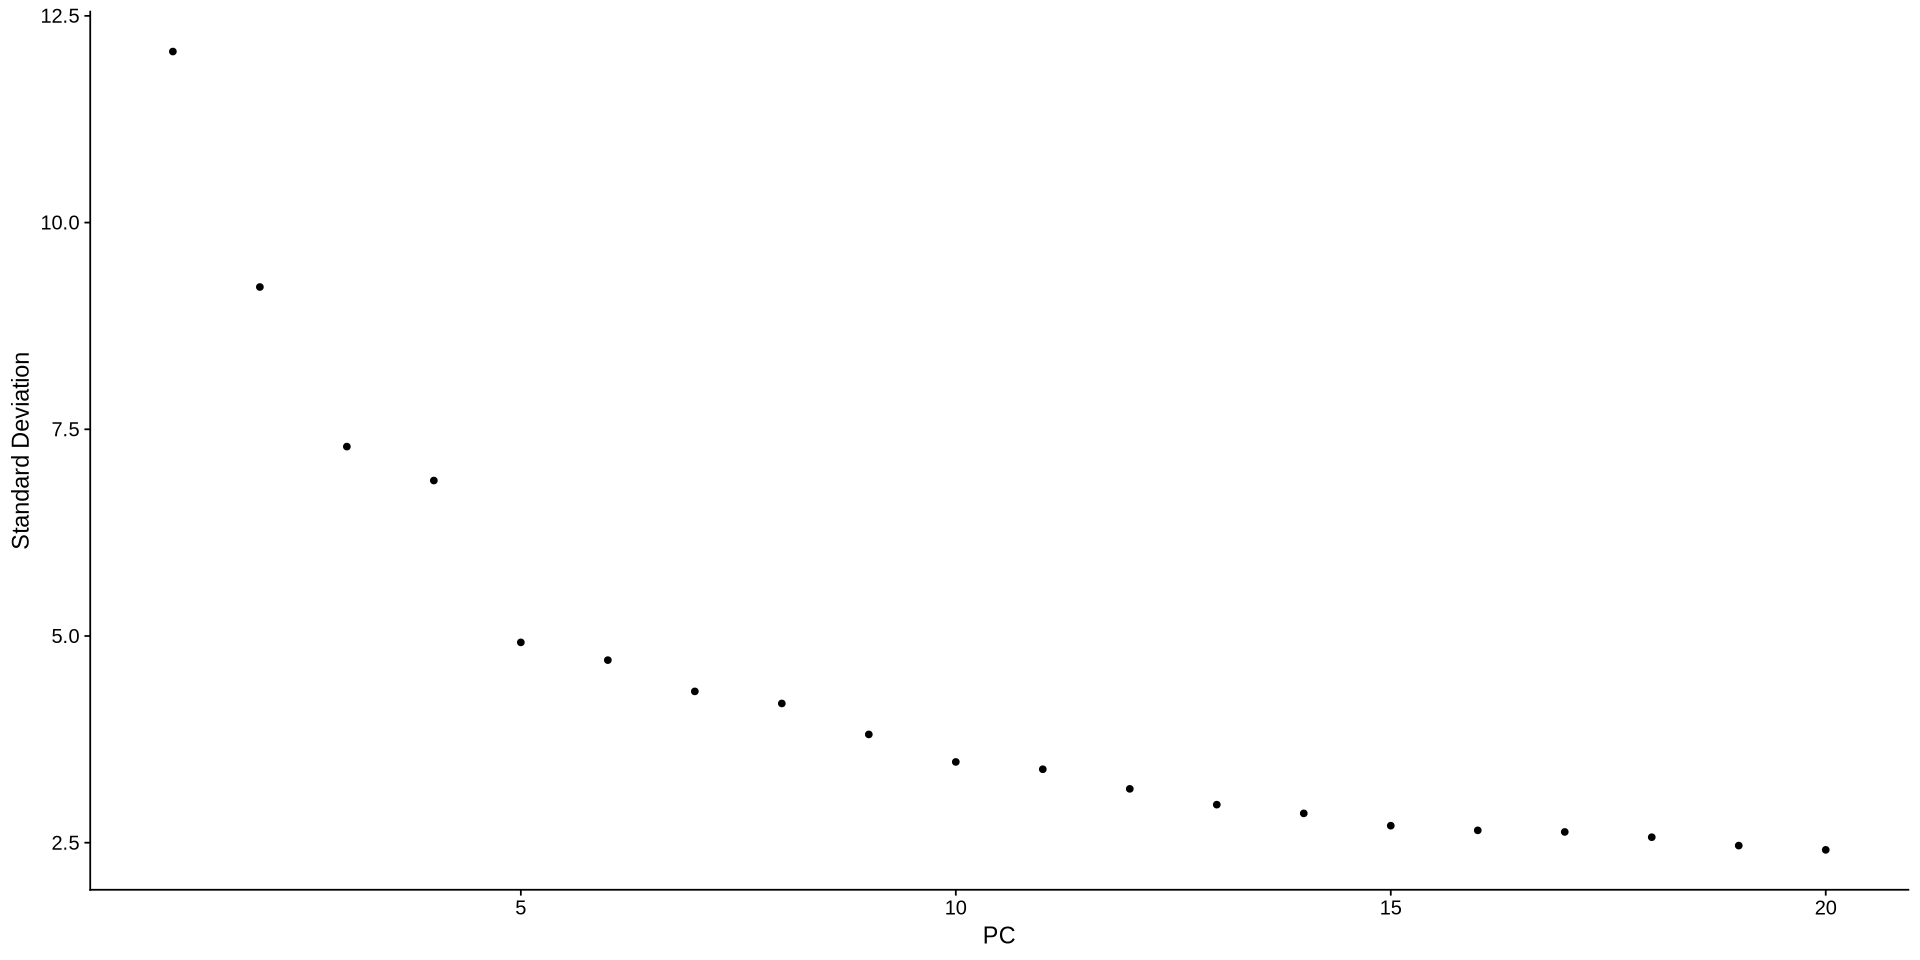

In [49]:
ElbowPlot(seger)

In [58]:
seger <- FindNeighbors(seger, dims = 1:10)
seger <- FindClusters(seger, resolution = 0.2)
head(Idents(seger), 5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1841
Number of edges: 53535

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9392
Number of communities: 7
Elapsed time: 0 seconds


AZ_A1 AZ_A3 AZ_A4 AZ_B6 AZ_B7 
    2     1     5     5     2 
Levels: 0 1 2 3 4 5 6

14:40:44 UMAP embedding parameters a = 0.9922 b = 1.112

14:40:44 Read 1841 rows and found 10 numeric columns

14:40:44 Using Annoy for neighbor search, n_neighbors = 30

14:40:44 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:40:44 Writing NN index file to temp file /tmp/RtmpX6DldY/filece31e5f785a

14:40:44 Searching Annoy index using 1 thread, search_k = 3000

14:40:44 Annoy recall = 100%

14:40:44 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:40:45 Initializing from normalized Laplacian + noise (using RSpectra)

14:40:45 Commencing optimization for 500 epochs, with 71660 positive edges

14:40:47 Optimization finished



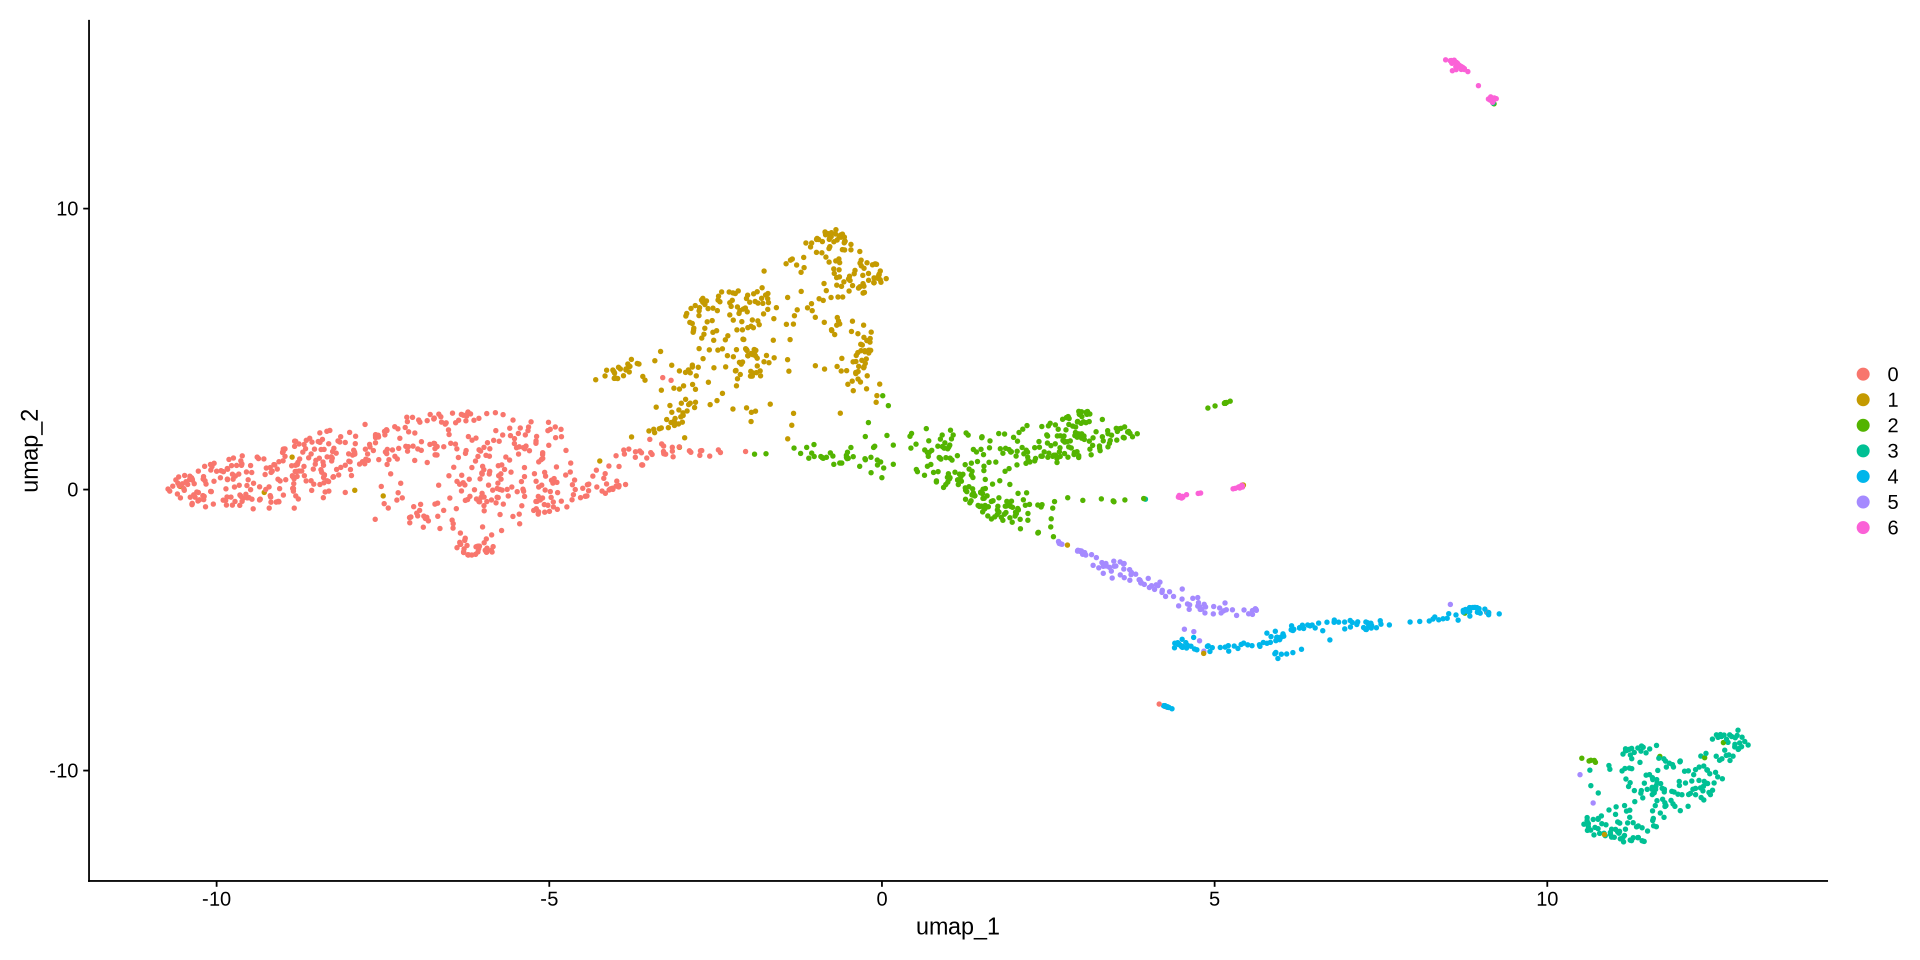

In [59]:
seger <- RunUMAP(seger, dims = 1:10)
DimPlot(seger, reduction = 'umap')

### Assigning cell type identity to clusters

In [60]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
seger.markers <- FindAllMarkers(seger, only.pos = TRUE)
seger.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    head()

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene  
1 2.324210e-237 3.200513   1.000 0.981 4.655160e-233 0       TTR   
2 5.749030e-224 3.194304   0.843 0.101 1.151473e-219 0       IRX2  
3 3.486772e-220 2.868927   0.998 0.674 6.983655e-216 0       PCSK2 
4 1.478882e-217 3.329620   0.932 0.270 2.962053e-213 0       F10   
5 5.570023e-211 3.641899   1.000 0.962 1.115620e-206 0       GCG   
6 3.221412e-210 2.917780   1.000 0.804 6.452167e-206 0       TM4SF4

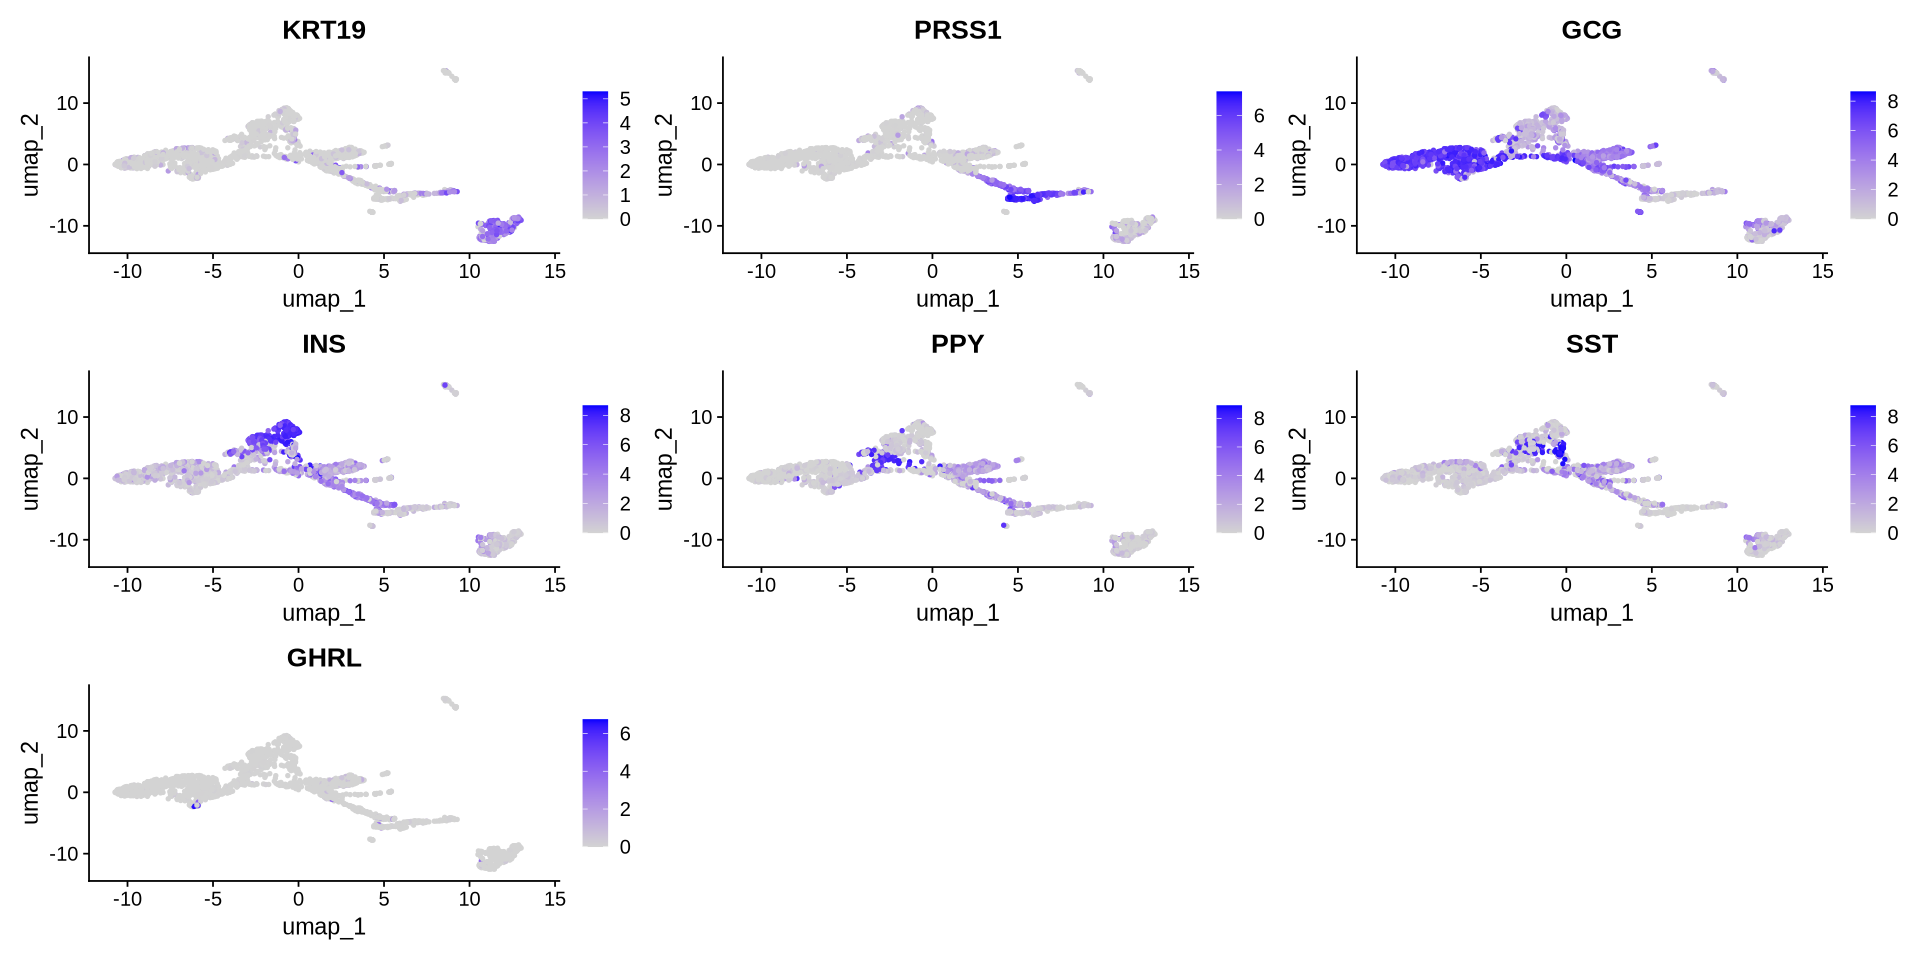

In [61]:
FeaturePlot(seger, features = c("KRT19", "PRSS1", "GCG", "INS", "PPY", "SST", "GHRL"))

## baron data

### Getting baron data

In [93]:
# Hint:
# 1. Need to reorder the cells to make them match between count and cell.meta
# 2. Need to select the healthy individuals (and remove the T2D patients)

###########################################################################
# Paper: PMID 27667667
# Data link (available in paper):
# https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-5061
###########################################################################

baron1=read.csv('../data/GSE84133_RAW/GSM2230757_human1_umifm_counts.csv.gz')
baron2=read.csv('../data/GSE84133_RAW/GSM2230758_human2_umifm_counts.csv.gz')
baron3=read.csv('../data/GSE84133_RAW/GSM2230759_human3_umifm_counts.csv.gz')
baron4=read.csv('../data/GSE84133_RAW/GSM2230760_human4_umifm_counts.csv.gz')

In [94]:
head(baron1)

X                           barcode             assigned_cluster A1BG A1CF
1 human1_lib1.final_cell_0001 GATGACGGAC-GGTGGGAT acinar           0    4   
2 human1_lib1.final_cell_0002 GAGCGTTGCT-ACCTTCTT acinar           0    0   
3 human1_lib1.final_cell_0003 CTTACGGG-CCATTACT   acinar           0    0   
4 human1_lib1.final_cell_0004 GATGTACACG-TTAAACTG acinar           0    0   
5 human1_lib1.final_cell_0005 GAGATTGCGA-GTCGTCGT acinar           0    0   
6 human1_lib1.final_cell_0006 AATCCCACG-ATTCGACG  acinar           0    1   
  A2M A2ML1 A4GALT A4GNT AA06 ⋯ ZWILCH ZWINT ZXDA ZXDB ZXDC ZYG11B ZYX ZZEF1
1 0   0     0      0     0    ⋯ 0      0     0    0    0    0      2   0    
2 0   0     0      0     0    ⋯ 0      0     0    0    0    1      4   0    
3 0   0     0      0     0    ⋯ 0      0     0    0    0    0      0   0    
4 0   0     0      0     0    ⋯ 1      0     0    0    0    1      3   1    
5 0   0     0      0     0    ⋯ 0      0     0    0    0    0      1   0    
6 0   0     0      0     0    ⋯ 0      0     0    0    0    0      1   1    
  ZZZ3 pk
1 0    1 
2 1    0 
3 0    0 
4 0    0 
5 0    1 
6 1    0

In [95]:
# Check that the columns are the same before combining rows
all(colnames(baron1)==colnames(baron2))
all(colnames(baron1)==colnames(baron3))
all(colnames(baron1)==colnames(baron4))

[1] TRUE

[1] TRUE

[1] TRUE

In [96]:
baron_df=rbind(baron1, baron2, baron3, baron4)
rm(baron1,baron2,baron3,baron4)
head(baron_df)

X                           barcode             assigned_cluster A1BG A1CF
1 human1_lib1.final_cell_0001 GATGACGGAC-GGTGGGAT acinar           0    4   
2 human1_lib1.final_cell_0002 GAGCGTTGCT-ACCTTCTT acinar           0    0   
3 human1_lib1.final_cell_0003 CTTACGGG-CCATTACT   acinar           0    0   
4 human1_lib1.final_cell_0004 GATGTACACG-TTAAACTG acinar           0    0   
5 human1_lib1.final_cell_0005 GAGATTGCGA-GTCGTCGT acinar           0    0   
6 human1_lib1.final_cell_0006 AATCCCACG-ATTCGACG  acinar           0    1   
  A2M A2ML1 A4GALT A4GNT AA06 ⋯ ZWILCH ZWINT ZXDA ZXDB ZXDC ZYG11B ZYX ZZEF1
1 0   0     0      0     0    ⋯ 0      0     0    0    0    0      2   0    
2 0   0     0      0     0    ⋯ 0      0     0    0    0    1      4   0    
3 0   0     0      0     0    ⋯ 0      0     0    0    0    0      0   0    
4 0   0     0      0     0    ⋯ 1      0     0    0    0    1      3   1    
5 0   0     0      0     0    ⋯ 0      0     0    0    0    0      1   0    
6 0   0     0      0     0    ⋯ 0      0     0    0    0    0      1   1    
  ZZZ3 pk
1 0    1 
2 1    0 
3 0    0 
4 0    0 
5 0    1 
6 1    0

In [97]:
cell.meta=baron_df[,1:3]
colnames(cell.meta)[1]='cell'
head(cell.meta)

cell                        barcode             assigned_cluster
1 human1_lib1.final_cell_0001 GATGACGGAC-GGTGGGAT acinar          
2 human1_lib1.final_cell_0002 GAGCGTTGCT-ACCTTCTT acinar          
3 human1_lib1.final_cell_0003 CTTACGGG-CCATTACT   acinar          
4 human1_lib1.final_cell_0004 GATGTACACG-TTAAACTG acinar          
5 human1_lib1.final_cell_0005 GAGATTGCGA-GTCGTCGT acinar          
6 human1_lib1.final_cell_0006 AATCCCACG-ATTCGACG  acinar

In [98]:
cell.meta$individual=substr(cell.meta$cell, start=1, stop=6)
head(cell.meta, 3)

cell                        barcode             assigned_cluster individual
1 human1_lib1.final_cell_0001 GATGACGGAC-GGTGGGAT acinar           human1    
2 human1_lib1.final_cell_0002 GAGCGTTGCT-ACCTTCTT acinar           human1    
3 human1_lib1.final_cell_0003 CTTACGGG-CCATTACT   acinar           human1

In [99]:
table(cell.meta$individual)


human1 human2 human3 human4 
  1937   1724   3605   1303 

In [100]:
count=as.matrix(baron_df[,-(1:3)])
rm(baron_df)
head(count)

A1BG A1CF A2M A2ML1 A4GALT A4GNT AA06 AAAS AACS AACSP1 ⋯ ZWILCH ZWINT ZXDA
[1,] 0    4    0   0     0      0     0    0    0    0      ⋯ 0      0     0   
[2,] 0    0    0   0     0      0     0    0    2    0      ⋯ 0      0     0   
[3,] 0    0    0   0     0      0     0    0    0    0      ⋯ 0      0     0   
[4,] 0    0    0   0     0      0     0    1    0    0      ⋯ 1      0     0   
[5,] 0    0    0   0     0      0     0    0    0    0      ⋯ 0      0     0   
[6,] 0    1    0   0     0      0     0    0    2    0      ⋯ 0      0     0   
     ZXDB ZXDC ZYG11B ZYX ZZEF1 ZZZ3 pk
[1,] 0    0    0      2   0     0    1 
[2,] 0    0    1      4   0     1    0 
[3,] 0    0    0      0   0     0    0 
[4,] 0    0    1      3   1     0    0 
[5,] 0    0    0      1   0     0    1 
[6,] 0    0    0      1   1     1    0

In [101]:
rownames(count)=cell.meta$cell
rownames(cell.meta)=cell.meta$cell
colnames(cell.meta)[3]='celltype'
head(count, 3)

A1BG A1CF A2M A2ML1 A4GALT A4GNT AA06 AAAS AACS
human1_lib1.final_cell_0001 0    4    0   0     0      0     0    0    0   
human1_lib1.final_cell_0002 0    0    0   0     0      0     0    0    2   
human1_lib1.final_cell_0003 0    0    0   0     0      0     0    0    0   
                            AACSP1 ⋯ ZWILCH ZWINT ZXDA ZXDB ZXDC ZYG11B ZYX
human1_lib1.final_cell_0001 0      ⋯ 0      0     0    0    0    0      2  
human1_lib1.final_cell_0002 0      ⋯ 0      0     0    0    0    1      4  
human1_lib1.final_cell_0003 0      ⋯ 0      0     0    0    0    0      0  
                            ZZEF1 ZZZ3 pk
human1_lib1.final_cell_0001 0     0    1 
human1_lib1.final_cell_0002 0     1    0 
human1_lib1.final_cell_0003 0     0    0

In [102]:
dim(count)

[1]  8569 20125

In [103]:
df2 = as.data.frame(count)

In [104]:
head(cell.meta, 3)

cell                        barcode            
human1_lib1.final_cell_0001 human1_lib1.final_cell_0001 GATGACGGAC-GGTGGGAT
human1_lib1.final_cell_0002 human1_lib1.final_cell_0002 GAGCGTTGCT-ACCTTCTT
human1_lib1.final_cell_0003 human1_lib1.final_cell_0003 CTTACGGG-CCATTACT  
                            celltype individual
human1_lib1.final_cell_0001 acinar   human1    
human1_lib1.final_cell_0002 acinar   human1    
human1_lib1.final_cell_0003 acinar   human1

In [126]:
table(cell.meta$celltype)


            acinar activated_stellate              alpha               beta 
               958                284               2326               2525 
             delta             ductal        endothelial            epsilon 
               601               1077                252                 18 
             gamma         macrophage               mast quiescent_stellate 
               255                 55                 25                173 
           schwann             t_cell 
                13                  7 

### Quality control

No duplicate rows or columns.

In [105]:
sum(duplicated(rownames(df2)))

[1] 0

In [106]:
sum(duplicated(colnames(df2)))

[1] 0

In [107]:
baron <- CreateSeuratObject(counts = t(df2), project = "baron", min.cells = 3, min.features = 200, meta.data = cell.meta)
baron

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”


An object of class Seurat 
16359 features across 8569 samples within 1 assay 
Active assay: RNA (16359 features, 0 variable features)
 1 layer present: counts

There is no mitochondrial data either.

In [108]:
sum(PercentageFeatureSet(baron, pattern = "^mt-"))

[1] 0

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


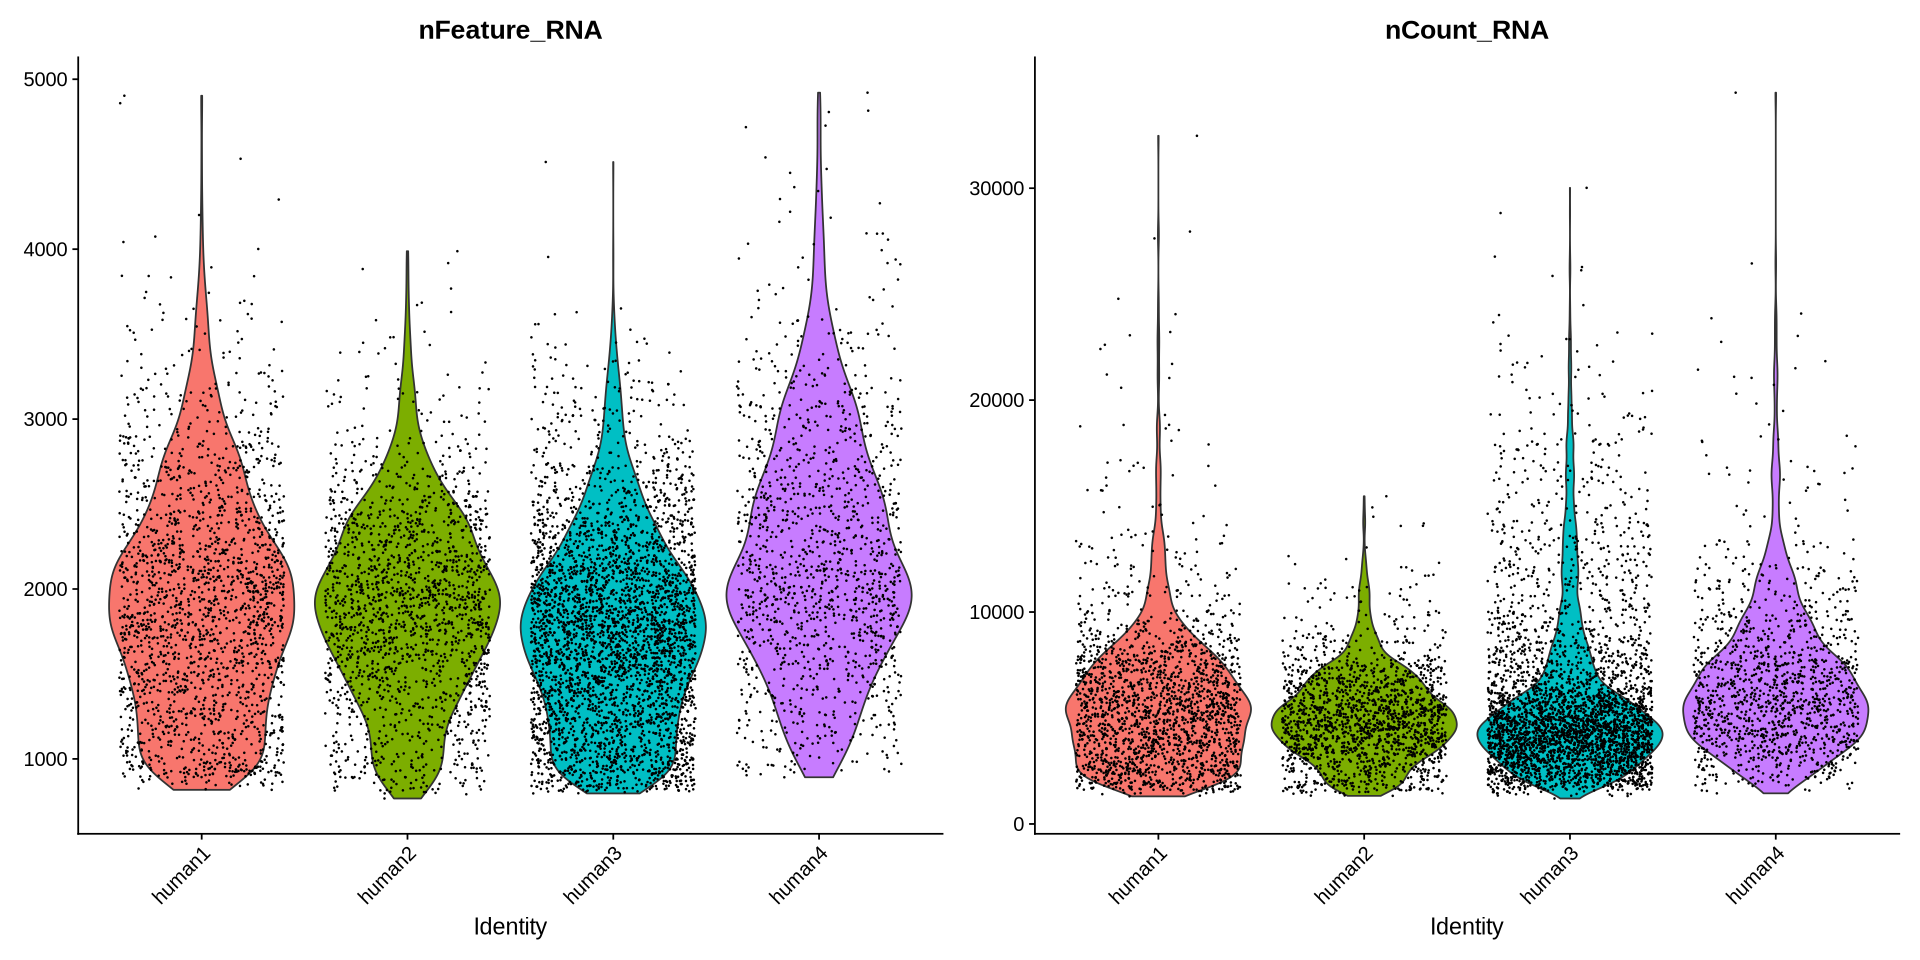

In [109]:
VlnPlot(baron, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

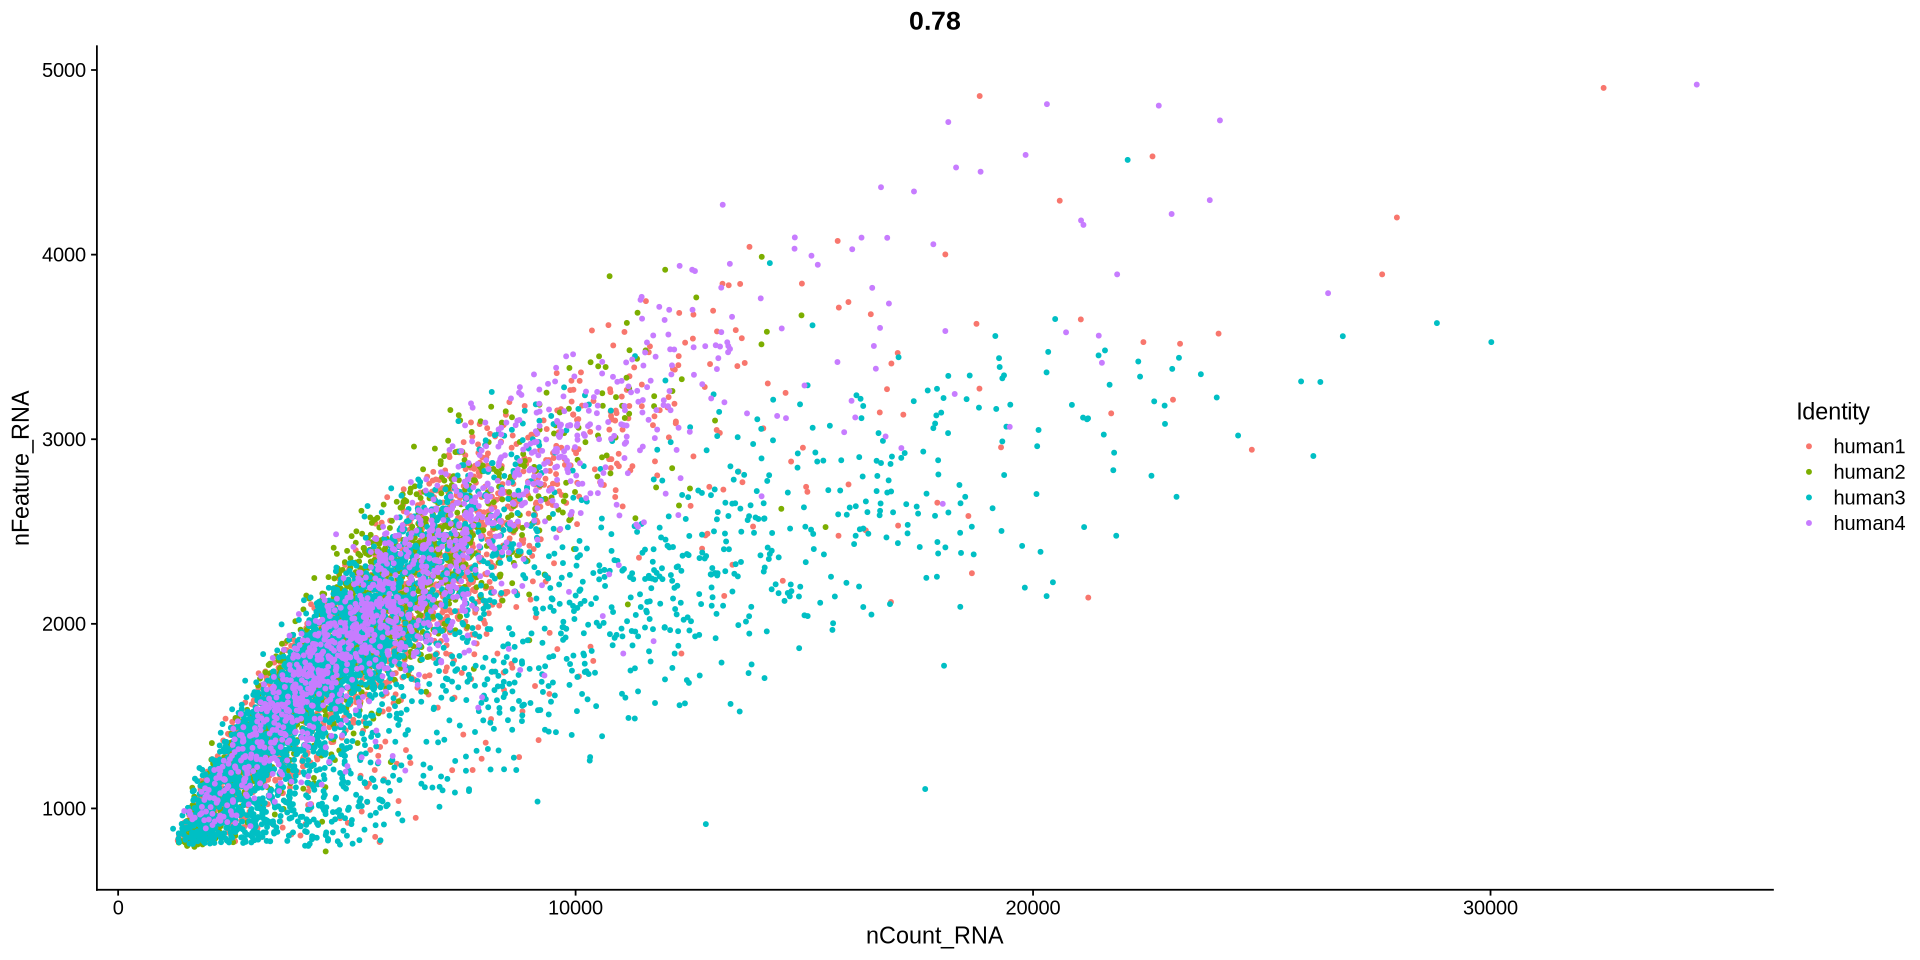

In [110]:
FeatureScatter(baron, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

In [111]:
baron = subset(baron, subset = nFeature_RNA > 800 & nFeature_RNA < 3500)

### Normalize the data

In [112]:
baron <- NormalizeData(baron)
baron

Normalizing layer: counts



An object of class Seurat 
16359 features across 8455 samples within 1 assay 
Active assay: RNA (16359 features, 0 variable features)
 2 layers present: counts, data

### Highly variable features

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results



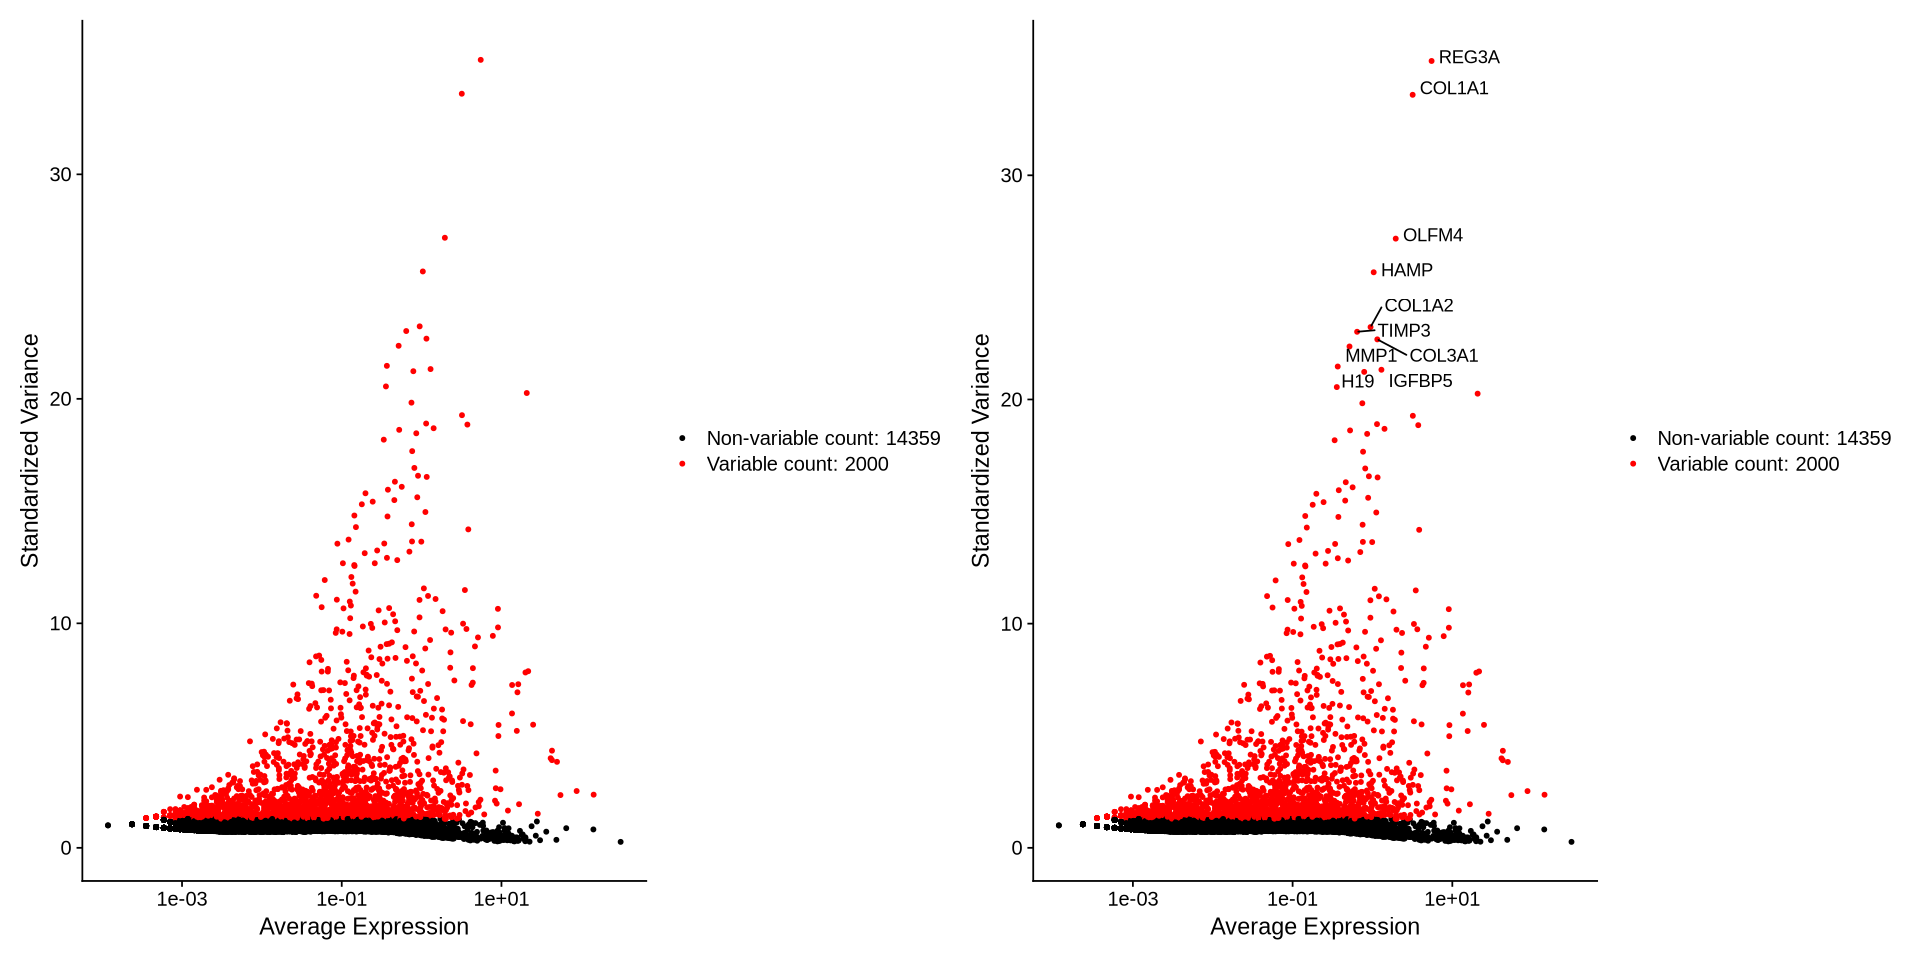

In [113]:
baron <- FindVariableFeatures(baron, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10_2 <- head(VariableFeatures(baron), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(baron)
plot2 <- LabelPoints(plot = plot1, points = top10_2, repel = TRUE)
plot1 + plot2

### Scaling data

In [114]:
all.genes <- rownames(baron)
baron <- ScaleData(baron, features = all.genes)

Centering and scaling data matrix



### PCA

PC_ 1 
Positive:  IFITM3, PMEPA1, TMSB10, COL18A1, IFITM2, ZFP36L1, CDC42EP1, SOX4, FLNA, MMP14 
	   SERPING1, ITGA5, YBX3, MSN, RHOC, TMSB4X, MYH9, LGALS1, S100A16, S100A11 
	   TACSTD2, HSPG2, SERPINH1, LGALS3, IL32, PFKFB3, CEBPB, KRT7, LITAF, CYR61 
Negative:  CHGA, CHGB, SCG2, PPP1R1A, VGF, PCSK2, GAD2, UCHL1, SLC30A8, ERO1B 
	   NEUROD1, SYT7, ABCC8, C1QL1, GNG4, PCSK1, PAPSS2, C2CD4A, UCN3, IAPP 
	   GCH1, PCP4, TMEM176B, STX1A, MAFB, CFC1, TMEM176A, INSM1, PAK3, C2CD4B 
PC_ 2 
Positive:  SERPINA3, CD24, KRT8, KRT18, SDC4, TACSTD2, CD44, PDZK1IP1, SPINK1, PRSS8 
	   KRT7, IL32, CTRB1, LCN2, PRSS2, CLDN4, CTRB2, REG1A, PRSS1, CPA2 
	   CPA1, PLA2G1B, CELA3A, CELA3B, MUC1, CPB1, KLK1, CTRC, ELF3, CLPS 
Negative:  SPARC, COL6A2, COL4A1, IGFBP4, BGN, ENG, PDGFRB, PXDN, COL3A1, COL1A2 
	   COL15A1, CYGB, AEBP1, COL1A1, COL6A3, COL6A1, ITGA1, COL5A1, TIMP1, EMILIN1 
	   COL5A3, TIMP3, HTRA3, CRLF1, LRRC32, MMP2, COL5A2, CRISPLD2, MFGE8, HIC1 
PC_ 3 
Positive:  CTRC, CELA3B, PNLIPRP1, 

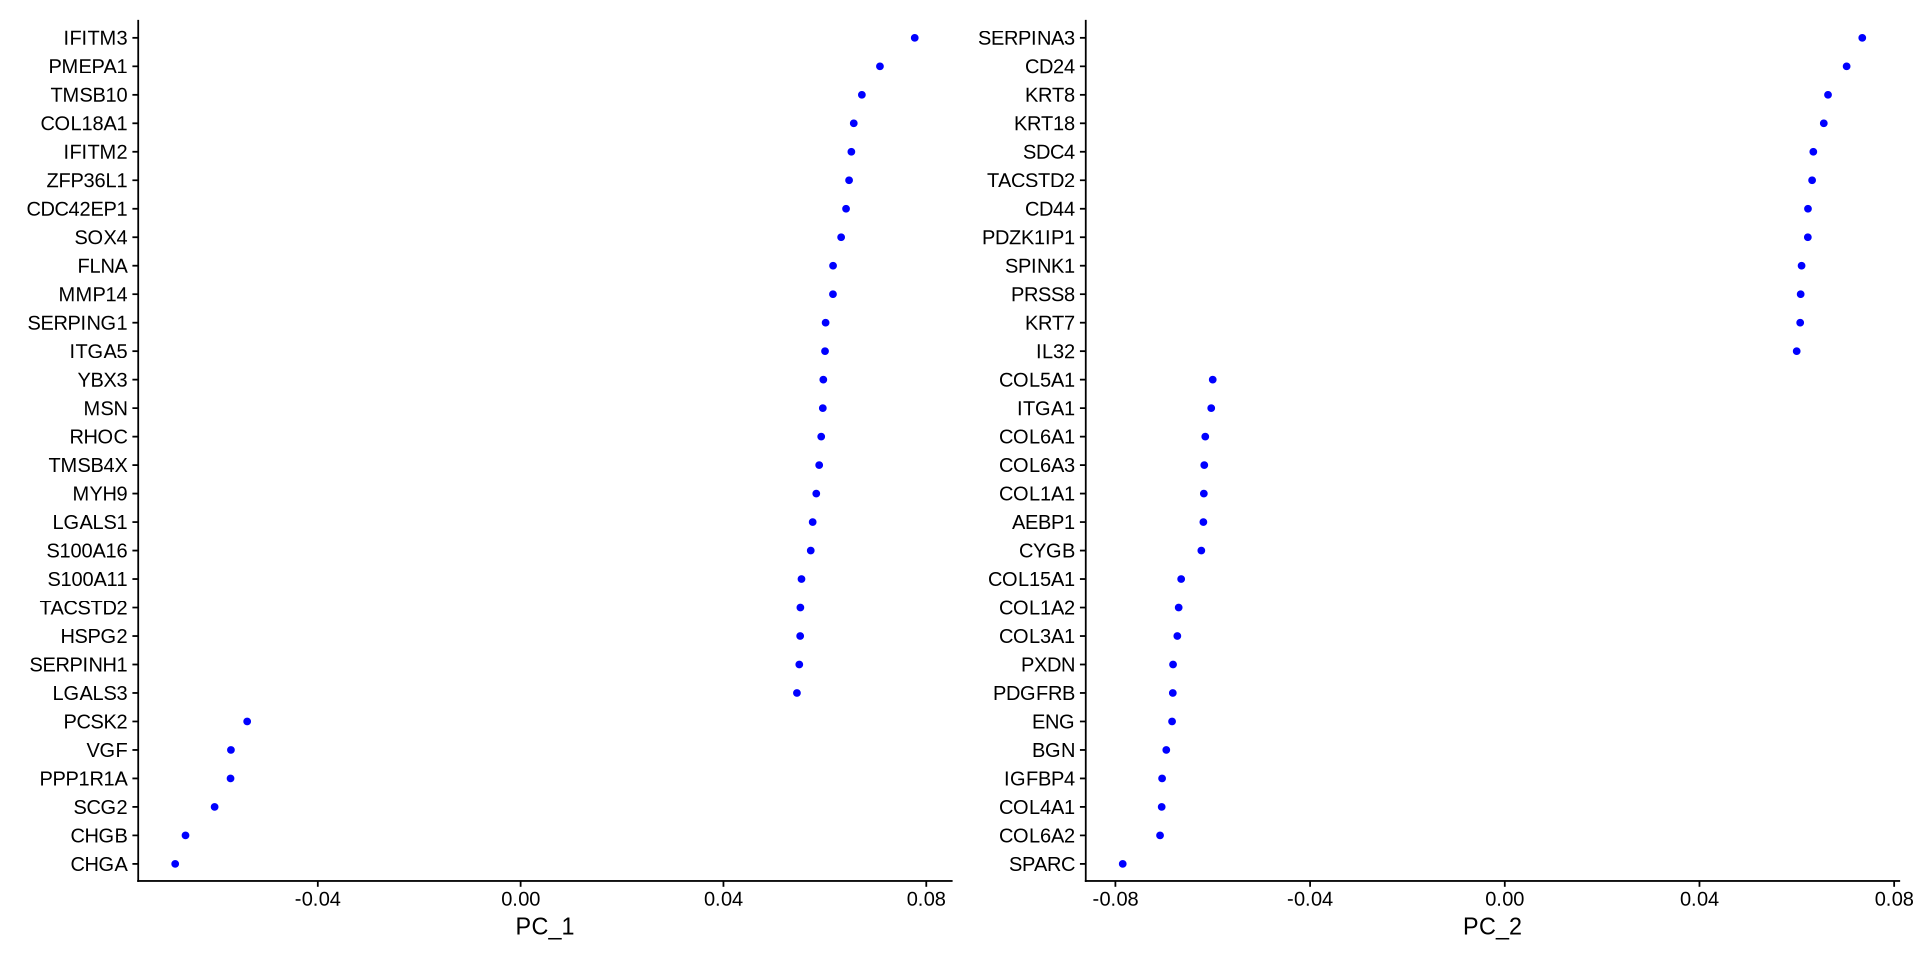

In [115]:
baron <- RunPCA(baron, features = VariableFeatures(object = baron))
VizDimLoadings(baron, dims = 1:2, reduction = "pca")

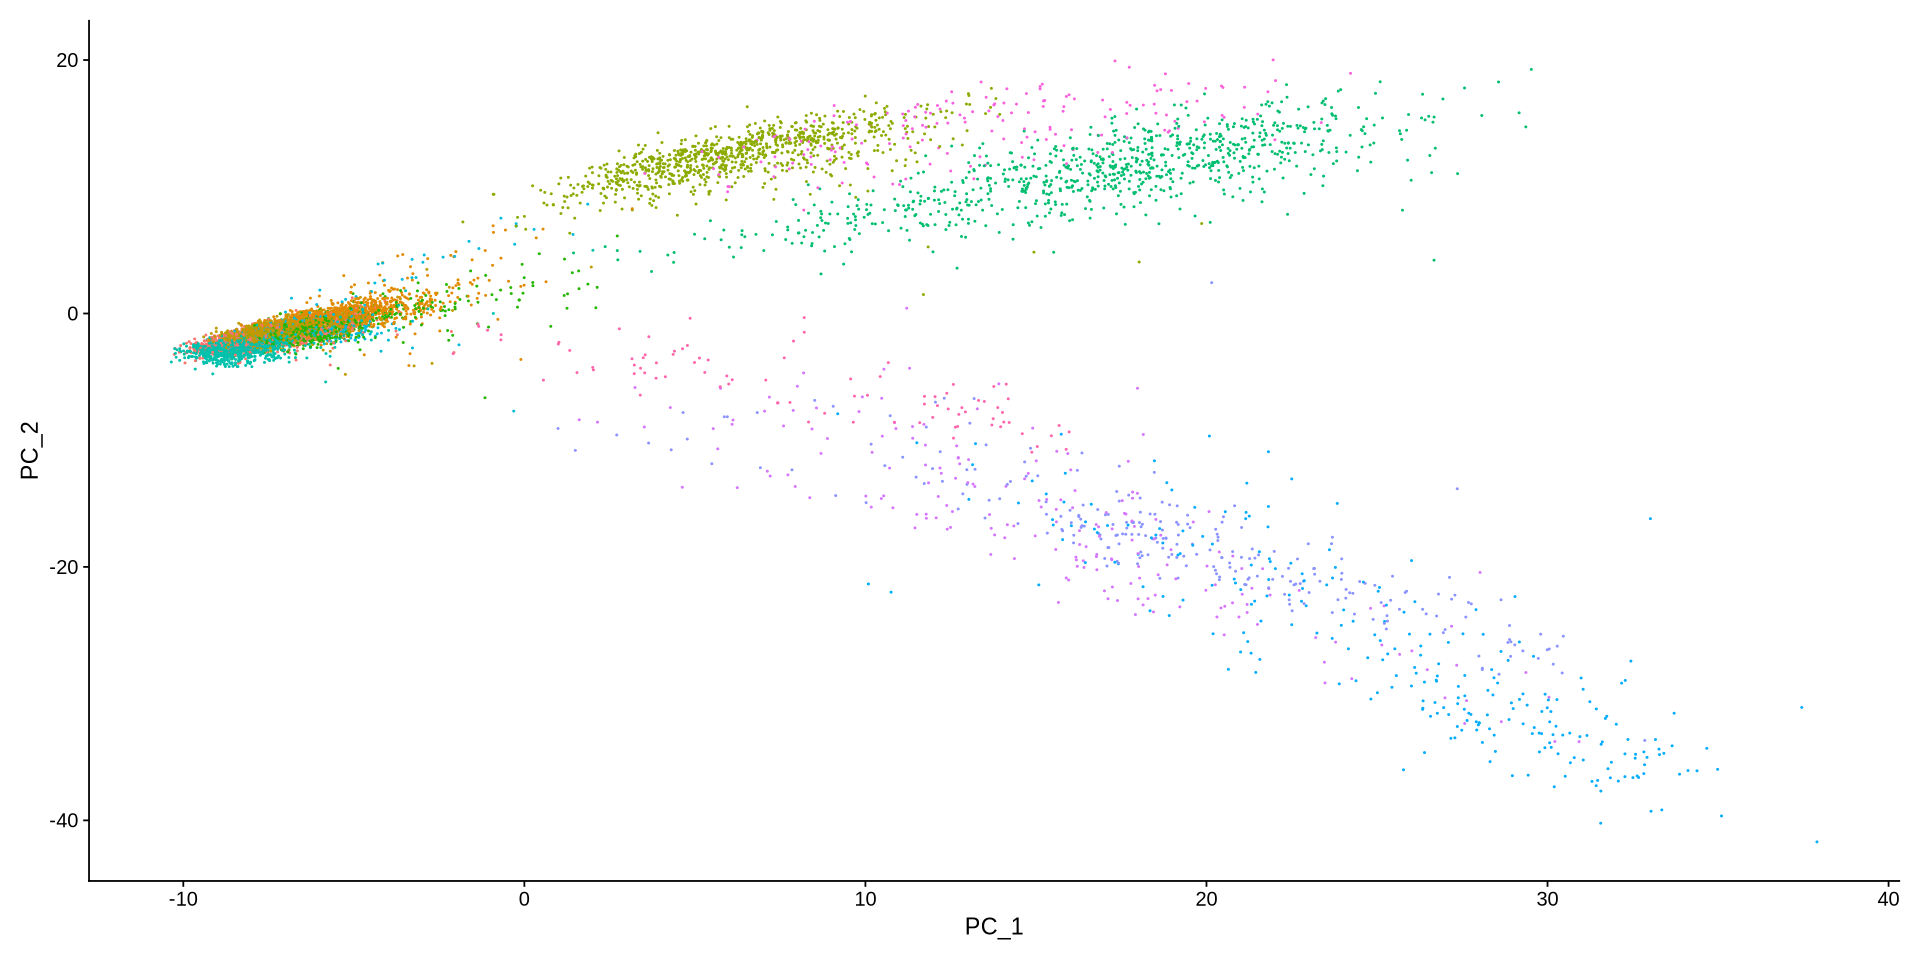

In [122]:
DimPlot(baron, reduction = "pca") + NoLegend()

### Determining the dimensionality of the dataset

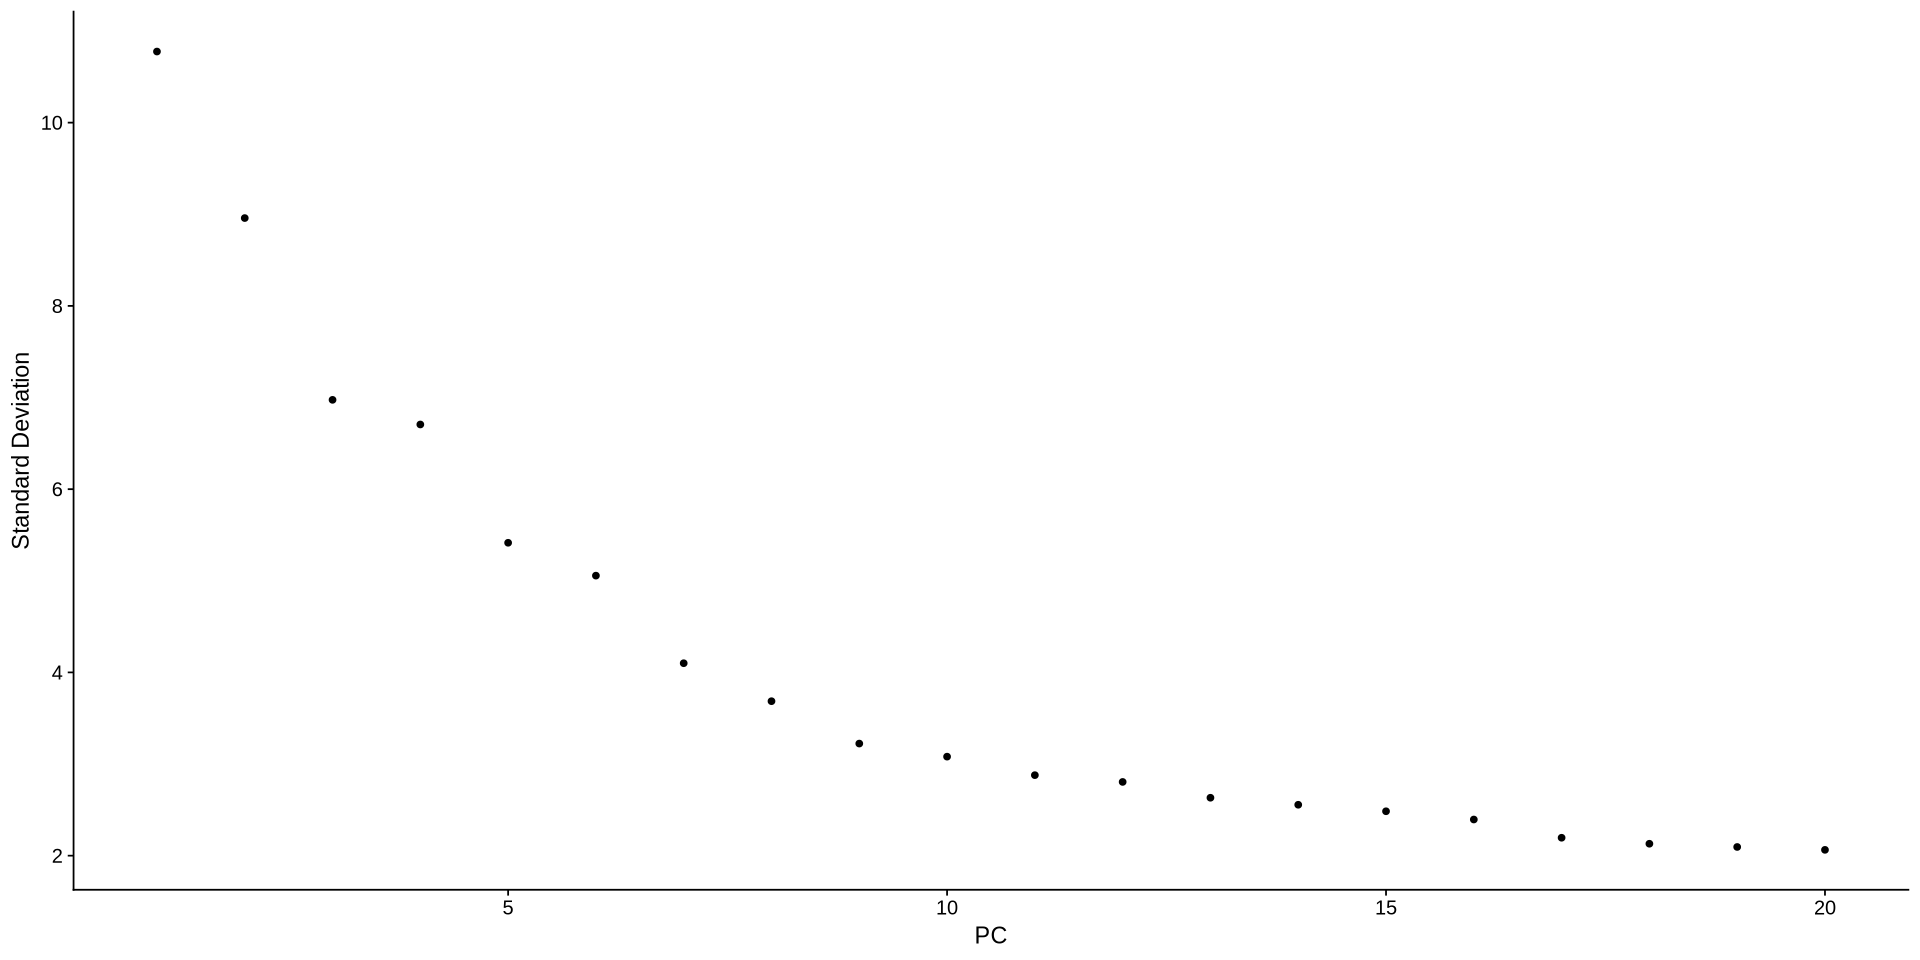

In [121]:
ElbowPlot(baron)

In [123]:
baron <- FindNeighbors(baron, dims = 1:10)
baron <- FindClusters(baron, resolution = 0.5)
head(Idents(baron), 5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8455
Number of edges: 282350

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9217
Number of communities: 13
Elapsed time: 0 seconds


human1_lib1.final_cell_0003 human1_lib1.final_cell_0004 
                          3                           3 
human1_lib1.final_cell_0005 human1_lib1.final_cell_0006 
                          3                           3 
human1_lib1.final_cell_0008 
                          3 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12

15:00:23 UMAP embedding parameters a = 0.9922 b = 1.112

15:00:23 Read 8455 rows and found 10 numeric columns

15:00:23 Using Annoy for neighbor search, n_neighbors = 30

15:00:23 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:00:24 Writing NN index file to temp file /tmp/RtmpX6DldY/filece31f195c48

15:00:24 Searching Annoy index using 1 thread, search_k = 3000

15:00:25 Annoy recall = 100%

15:00:26 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

15:00:26 Initializing from normalized Laplacian + noise (using RSpectra)

15:00:27 Commencing optimization for 500 epochs, with 345762 positive edges

15:00:33 Optimization finished



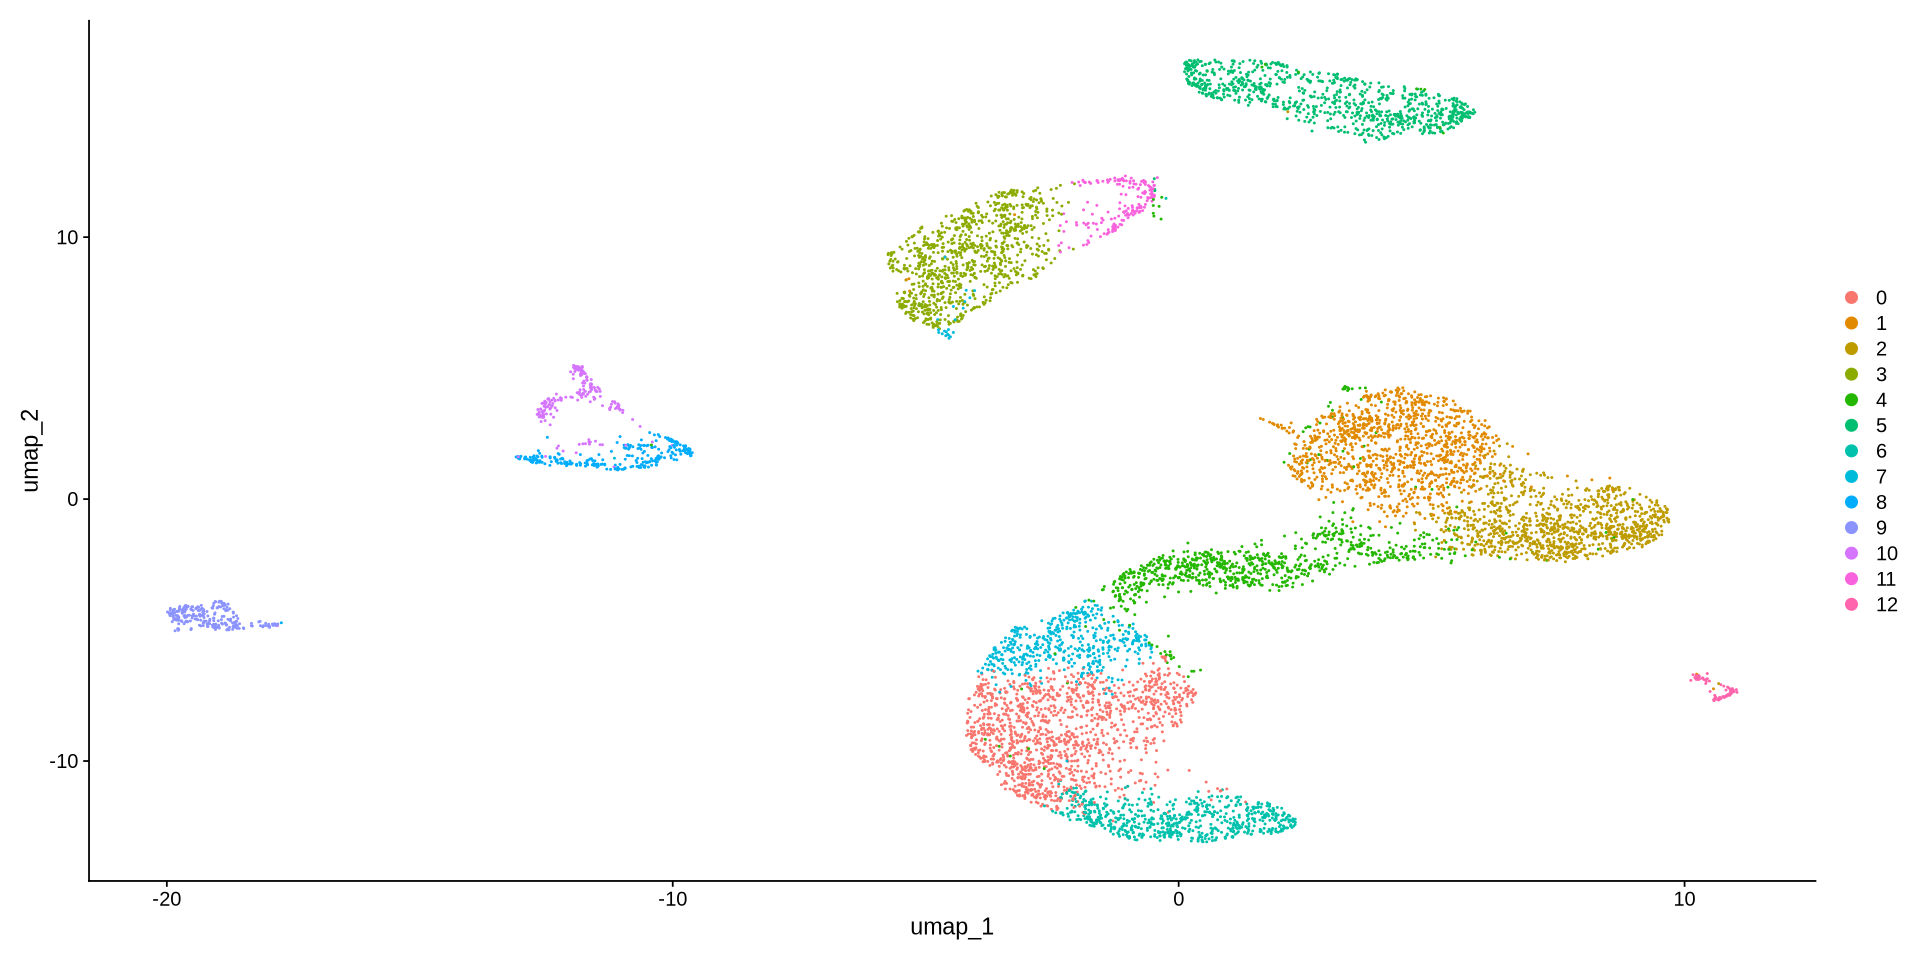

In [124]:
baron <- RunUMAP(baron, dims = 1:10)
DimPlot(baron, reduction = 'umap')

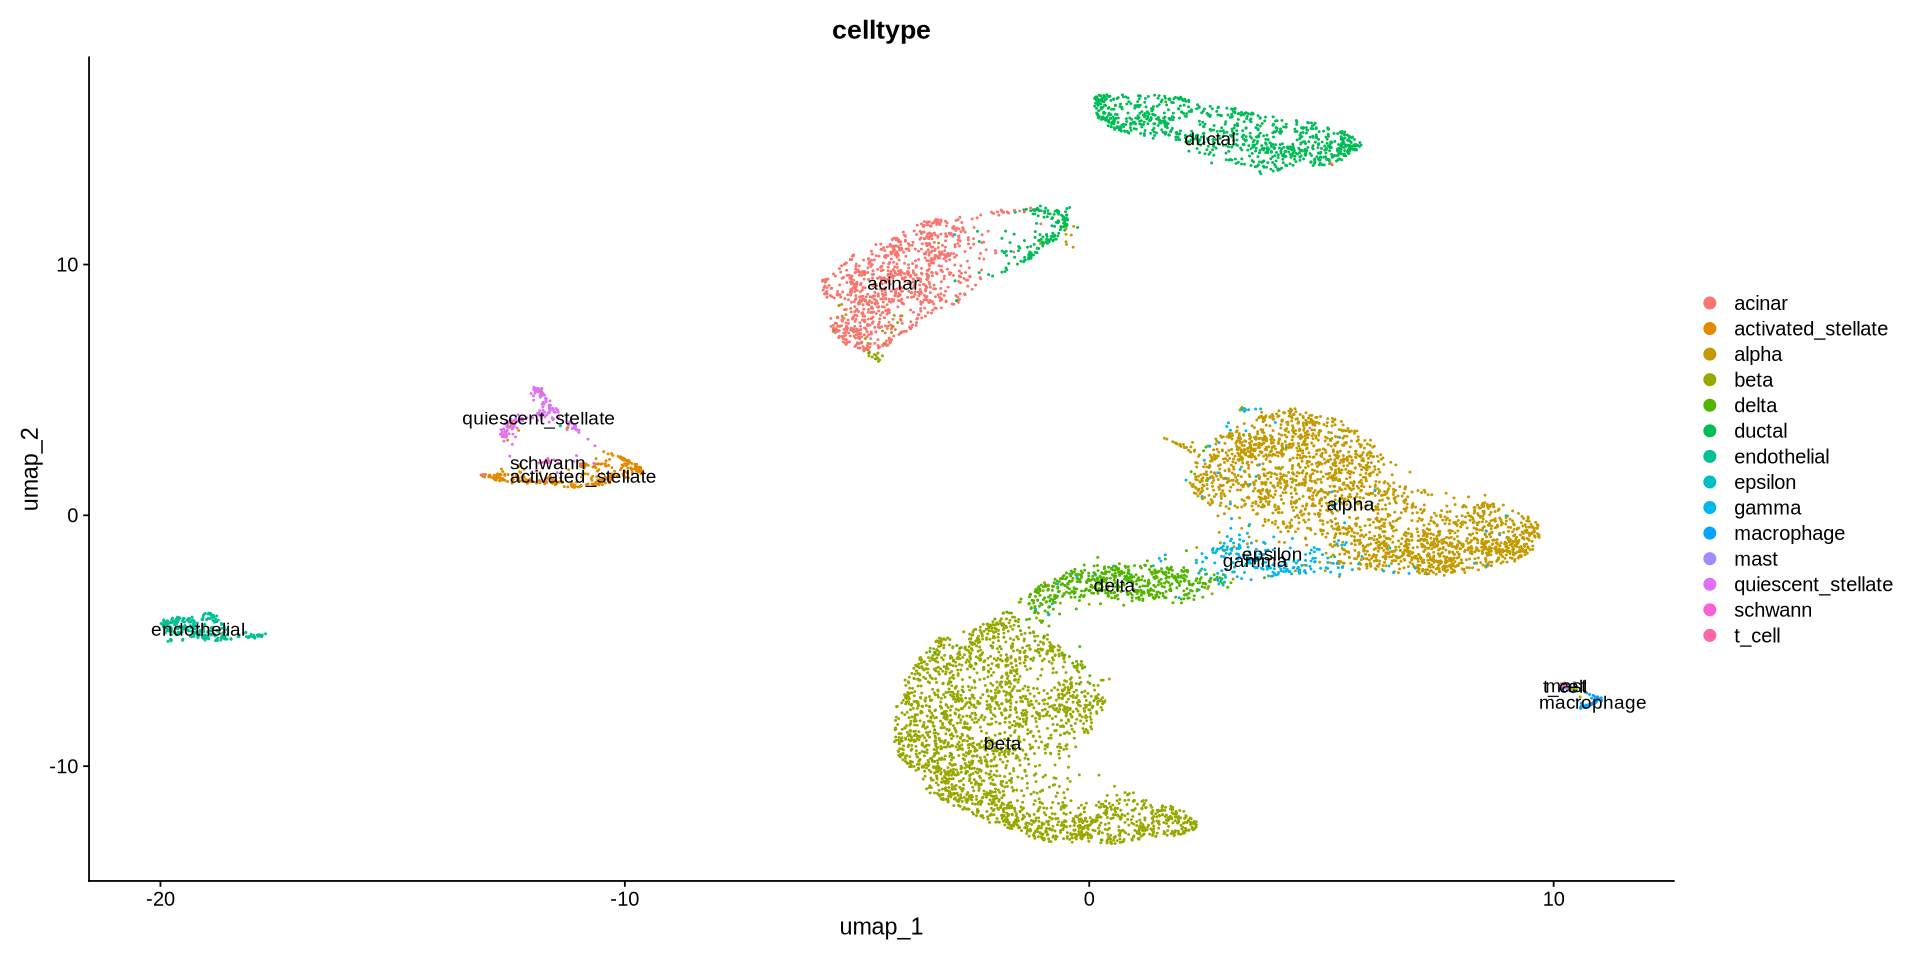

In [125]:
DimPlot(baron, reduction = 'umap', group.by = 'celltype', label = TRUE)

Calculating cluster acinar

Calculating cluster delta

Calculating cluster beta

Calculating cluster alpha

Calculating cluster activated_stellate

Calculating cluster ductal

Calculating cluster epsilon

Calculating cluster gamma

Calculating cluster endothelial

Calculating cluster quiescent_stellate

Calculating cluster macrophage

Calculating cluster schwann

Calculating cluster mast

Calculating cluster t_cell



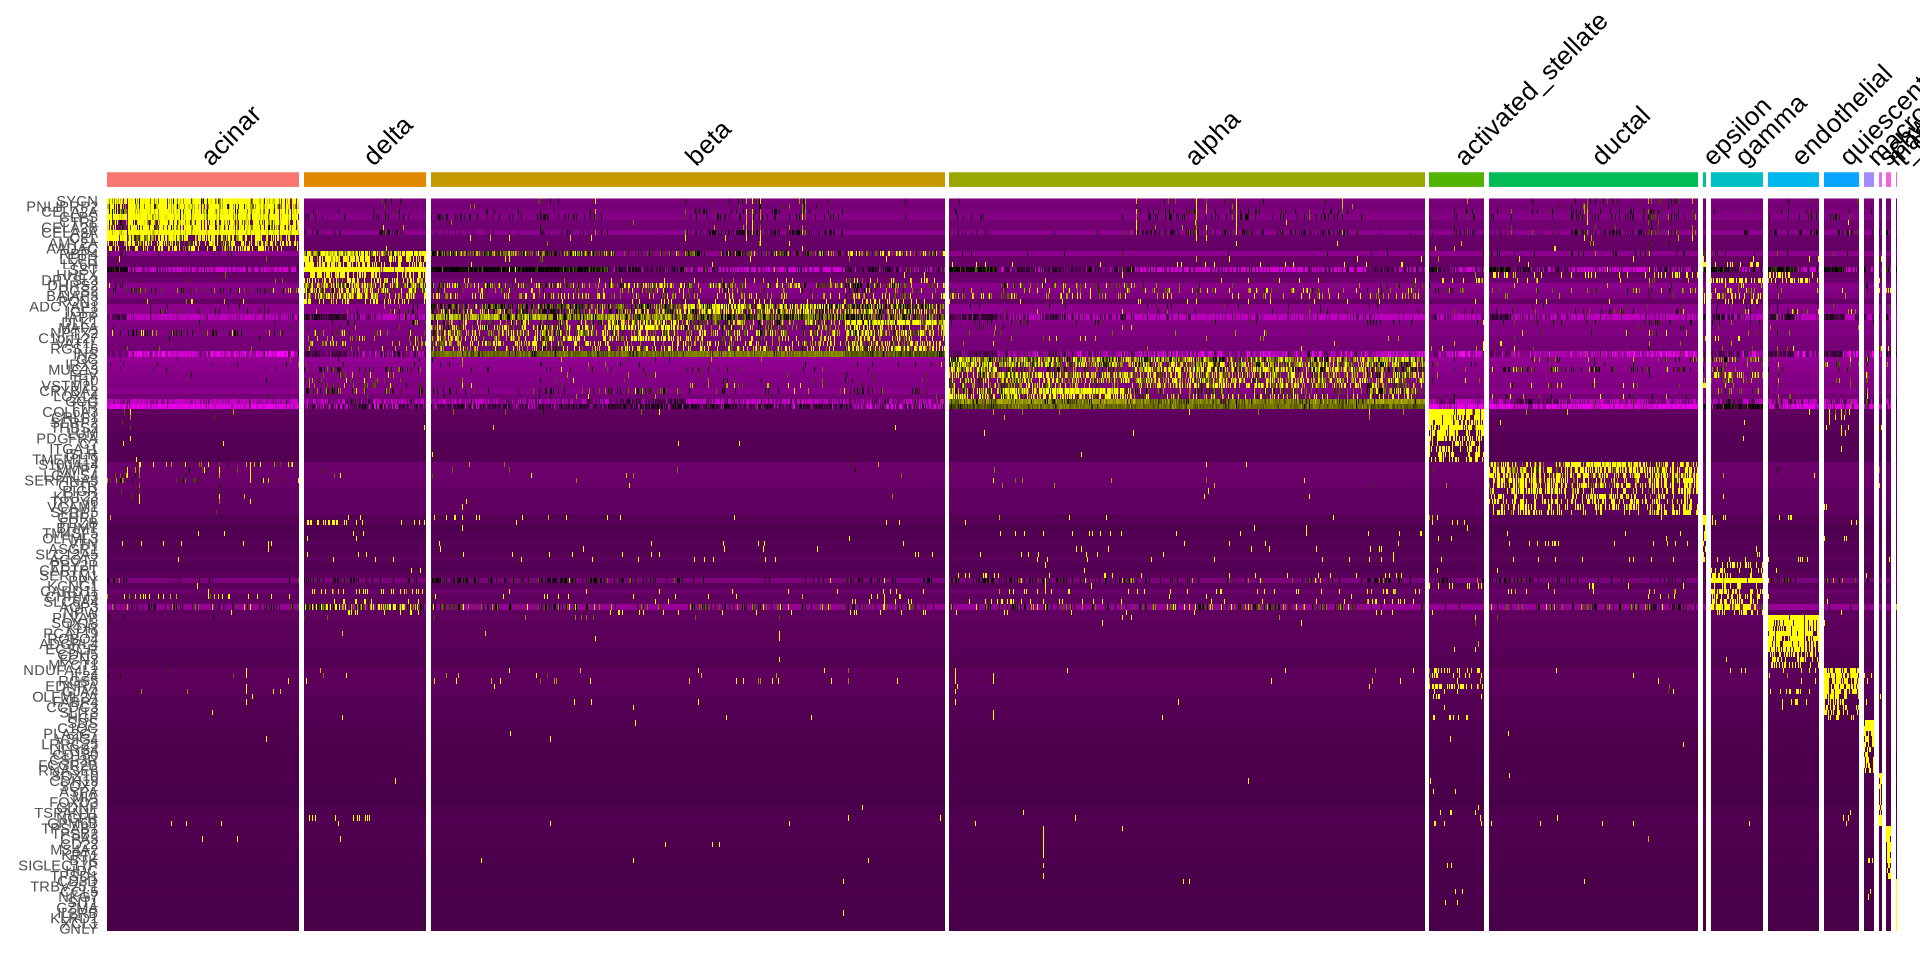

In [127]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
Idents(baron)=baron$celltype
baron.markers <- FindAllMarkers(baron, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
baron.markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(baron, features = top10$gene) + NoLegend()

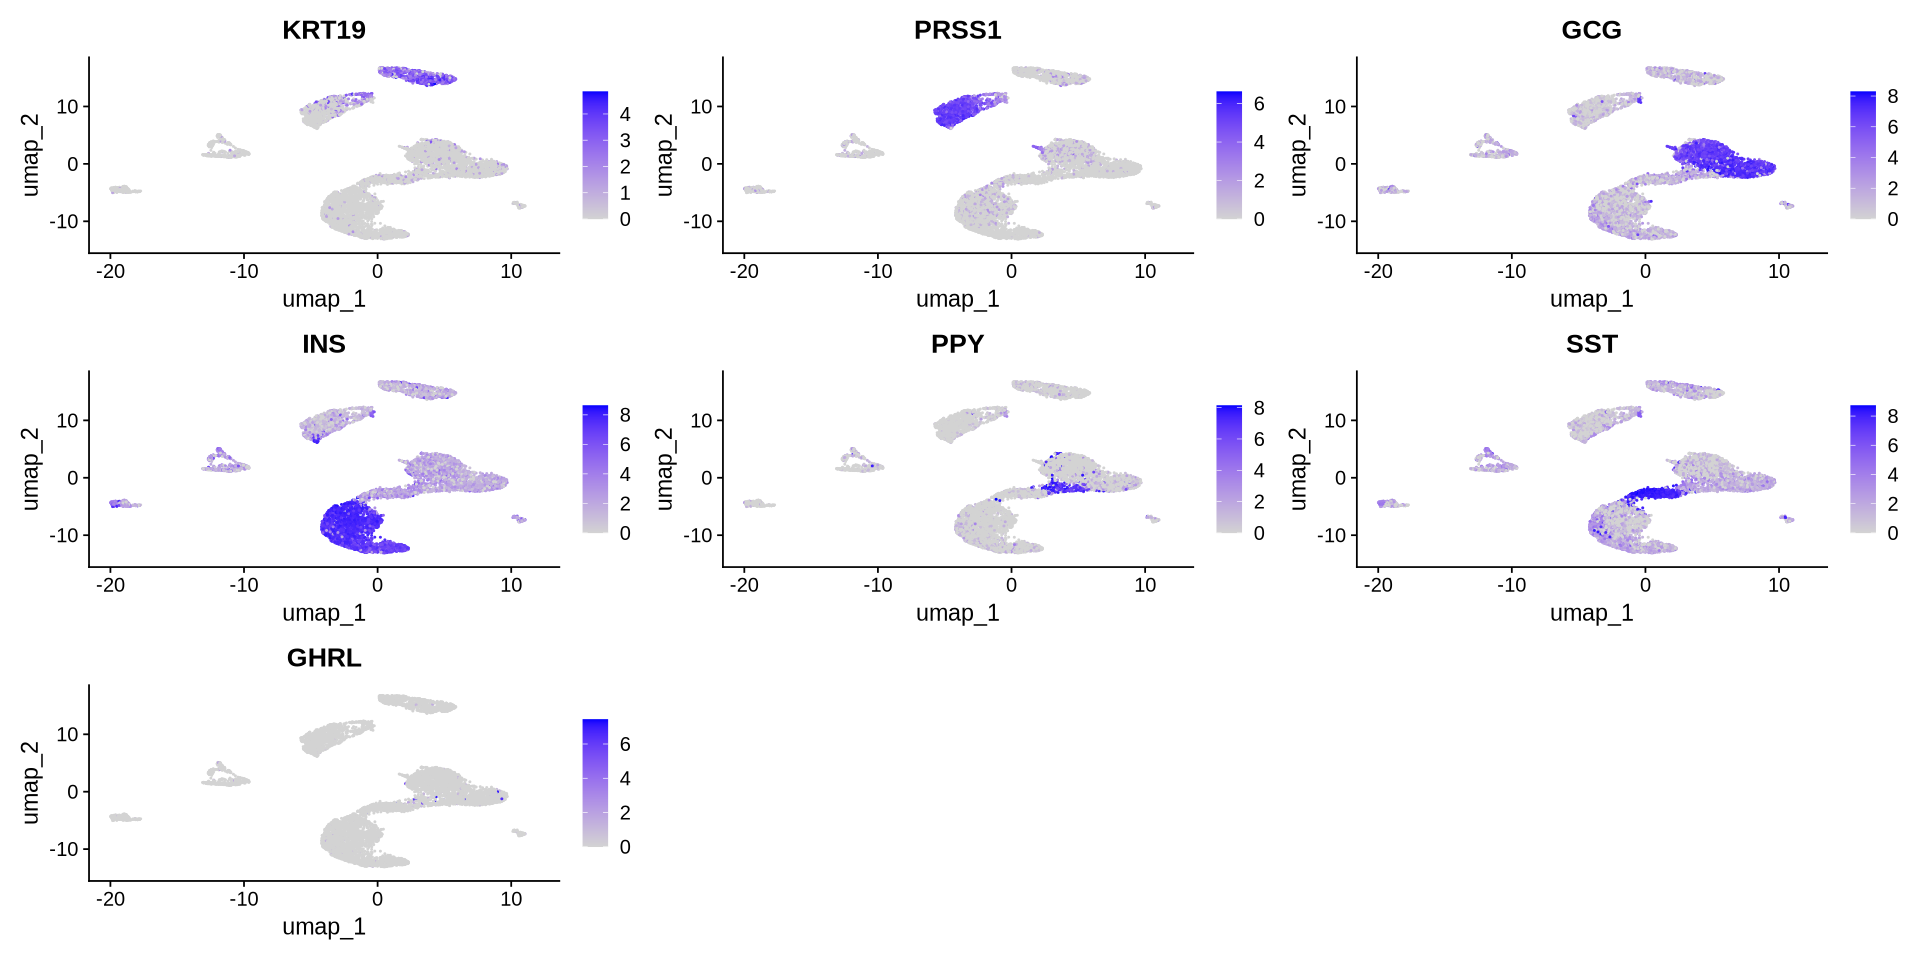

In [128]:
FeaturePlot(baron, features = c("KRT19", "PRSS1", "GCG", "INS", "PPY", "SST", "GHRL"))

## Top 10 cell-type-specific gene expressions

In [75]:
table(cell.meta$celltype)


            acinar activated_stellate              alpha               beta 
               958                284               2326               2525 
             delta             ductal        endothelial            epsilon 
               601               1077                252                 18 
             gamma         macrophage               mast quiescent_stellate 
               255                 55                 25                173 
           schwann             t_cell 
                13                  7 

In [113]:
head(cell.meta, 3)

cell                        barcode            
human1_lib1.final_cell_0001 human1_lib1.final_cell_0001 GATGACGGAC-GGTGGGAT
human1_lib1.final_cell_0002 human1_lib1.final_cell_0002 GAGCGTTGCT-ACCTTCTT
human1_lib1.final_cell_0003 human1_lib1.final_cell_0003 CTTACGGG-CCATTACT  
                            celltype individual
human1_lib1.final_cell_0001 acinar   human1    
human1_lib1.final_cell_0002 acinar   human1    
human1_lib1.final_cell_0003 acinar   human1

In [111]:
head(df2, 3)

A1BG A1CF A2M A2ML1 A4GALT A4GNT AA06 AAAS AACS
human1_lib1.final_cell_0001 0    4    0   0     0      0     0    0    0   
human1_lib1.final_cell_0002 0    0    0   0     0      0     0    0    2   
human1_lib1.final_cell_0003 0    0    0   0     0      0     0    0    0   
                            AACSP1 ⋯ ZWILCH ZWINT ZXDA ZXDB ZXDC ZYG11B ZYX
human1_lib1.final_cell_0001 0      ⋯ 0      0     0    0    0    0      2  
human1_lib1.final_cell_0002 0      ⋯ 0      0     0    0    0    1      4  
human1_lib1.final_cell_0003 0      ⋯ 0      0     0    0    0    0      0  
                            ZZEF1 ZZZ3 pk
human1_lib1.final_cell_0001 0     0    1 
human1_lib1.final_cell_0002 0     1    0 
human1_lib1.final_cell_0003 0     0    0

In [154]:
# Find differentially expressed features between CD14+ Monocytes and all other cells, only
# search for positive markers
markers <- FindMarkers(so2, ident.1 = 0, ident.2 = NULL, only.pos = TRUE)
# view results
head(markers)

p_val avg_log2FC pct.1 pct.2 p_val_adj
ADCYAP1 0     3.268922   0.803 0.151 0        
PCSK1   0     1.809494   0.862 0.257 0        
HADH    0     2.267413   0.882 0.280 0        
IGF2    0     2.368044   0.719 0.165 0        
ERO1B   0     2.370095   0.876 0.368 0        
UCHL1   0     1.580844   0.937 0.477 0

In [95]:
so2.markers

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
ADCYAP1   0.000000e+00 3.2689221  0.803 0.151  0.000000e+00 0       ADCYAP1 
PCSK1     0.000000e+00 1.8094943  0.862 0.257  0.000000e+00 0       PCSK1   
HADH      0.000000e+00 2.2674131  0.882 0.280  0.000000e+00 0       HADH    
IGF2      0.000000e+00 2.3680442  0.719 0.165  0.000000e+00 0       IGF2    
ERO1B     0.000000e+00 2.3700954  0.876 0.368  0.000000e+00 0       ERO1B   
UCHL1     0.000000e+00 1.5808439  0.937 0.477  0.000000e+00 0       UCHL1   
IAPP      0.000000e+00 3.3247250  0.975 0.526  0.000000e+00 0       IAPP    
MAFA      0.000000e+00 2.3542041  0.532 0.091  0.000000e+00 0       MAFA    
INS       0.000000e+00 2.6701778  0.999 0.903  0.000000e+00 0       INS     
PPP1R1A  2.400547e-305 1.6690483  0.924 0.481 3.927054e-301 0       PPP1R1A 
GAD2     1.310638e-303 1.9201621  0.906 0.448 2.144072e-299 0       GAD2    
ELMO1    3.761862e-291 2.3582459  0.539 0.119 6.154029e-287 0       ELMO1   
HOPX     5.664020e-252 2.0142645  0.567 0.152 9.265770e-248 0       HOPX    
ABCC8    4.320181e-238 1.4950394  0.766 0.296 7.067384e-234 0       ABCC8   
CPE      3.140783e-229 1.0879434  0.991 0.687 5.138007e-225 0       CPE     
STX1A    1.137481e-222 2.0410206  0.725 0.309 1.860805e-218 0       STX1A   
NPTX2    2.245026e-218 2.1609394  0.499 0.136 3.672638e-214 0       NPTX2   
C1orf127 6.199571e-216 2.1297465  0.398 0.081 1.014188e-211 0       C1orf127
NKX6.1   4.981845e-210 1.8920190  0.582 0.192 8.149801e-206 0       NKX6.1  
SLC2A13  1.138775e-202 2.0353150  0.513 0.154 1.862921e-198 0       SLC2A13 
PEMT     2.793494e-201 1.0465310  0.949 0.604 4.569877e-197 0       PEMT    
SYNGR4   4.918720e-201 1.8811885  0.547 0.172 8.046534e-197 0       SYNGR4  
SCGN     7.444955e-199 1.2785873  0.934 0.593 1.217920e-194 0       SCGN    
MEG3     2.316608e-196 1.3248333  0.544 0.162 3.789739e-192 0       MEG3    
RBP4     1.326959e-195 0.6926816  0.612 0.194 2.170773e-191 0       RBP4    
VAT1L    9.275835e-191 2.1221021  0.371 0.079 1.517434e-186 0       VAT1L   
PDX1     2.451033e-190 1.8623212  0.510 0.153 4.009645e-186 0       PDX1    
G6PC2    3.590219e-188 2.0554692  0.582 0.211 5.873240e-184 0       G6PC2   
C1QL1    8.312164e-180 1.0987678  0.722 0.286 1.359787e-175 0       C1QL1   
SLC6A17  1.077220e-173 1.9947642  0.394 0.099 1.762224e-169 0       SLC6A17 
⋮        ⋮             ⋮          ⋮     ⋮     ⋮             ⋮       ⋮       
BIN12    0.007901003   1.0506903  0.181 0.099 1             12      BIN1    
IKBKG2   0.007912948   1.2142467  0.181 0.101 1             12      IKBKG   
HOXB63   0.007939321   2.7334983  0.043 0.012 1             12      HOXB6   
TGOLN23  0.007995412   0.8423576  0.521 0.447 1             12      TGOLN2  
HS6ST15  0.008023623   1.9031485  0.191 0.114 1             12      HS6ST1  
TMEM1274 0.008131115   0.8594329  0.351 0.255 1             12      TMEM127 
ATG9B    0.008298216   3.8200458  0.021 0.004 1             12      ATG9B   
RFX52    0.008428285   1.4005120  0.128 0.063 1             12      RFX5    
SRSF24   0.008489514   0.6582144  0.521 0.429 1             12      SRSF2   
TEX264   0.008587417   1.2073591  0.160 0.085 1             12      TEX264  
MSRB12   0.008686063   1.0645862  0.255 0.166 1             12      MSRB1   
DENND6A3 0.008780131   1.8284164  0.117 0.056 1             12      DENND6A 
GJB23    0.008792666   2.5762751  0.032 0.008 1             12      GJB2    
SUMO32   0.008883907   0.8432774  0.489 0.422 1             12      SUMO3   
USP49    0.008905643   1.4477542  0.160 0.087 1             12      USP4    
GBP41    0.008926240   2.4375750  0.032 0.008 1             12      GBP4    
LY751    0.008927062   2.8380635  0.043 0.012 1             12      LY75    
NIN2     0.008936342   2.3283444  0.064 0.023 1             12      NIN     
CUL14    0.009035802   0.8962992  0.223 0.131 1             12      CUL1    
ZNF5861  0.009086373   2.5269794  0.043 0.012 1             12      ZNF586  
BACH1

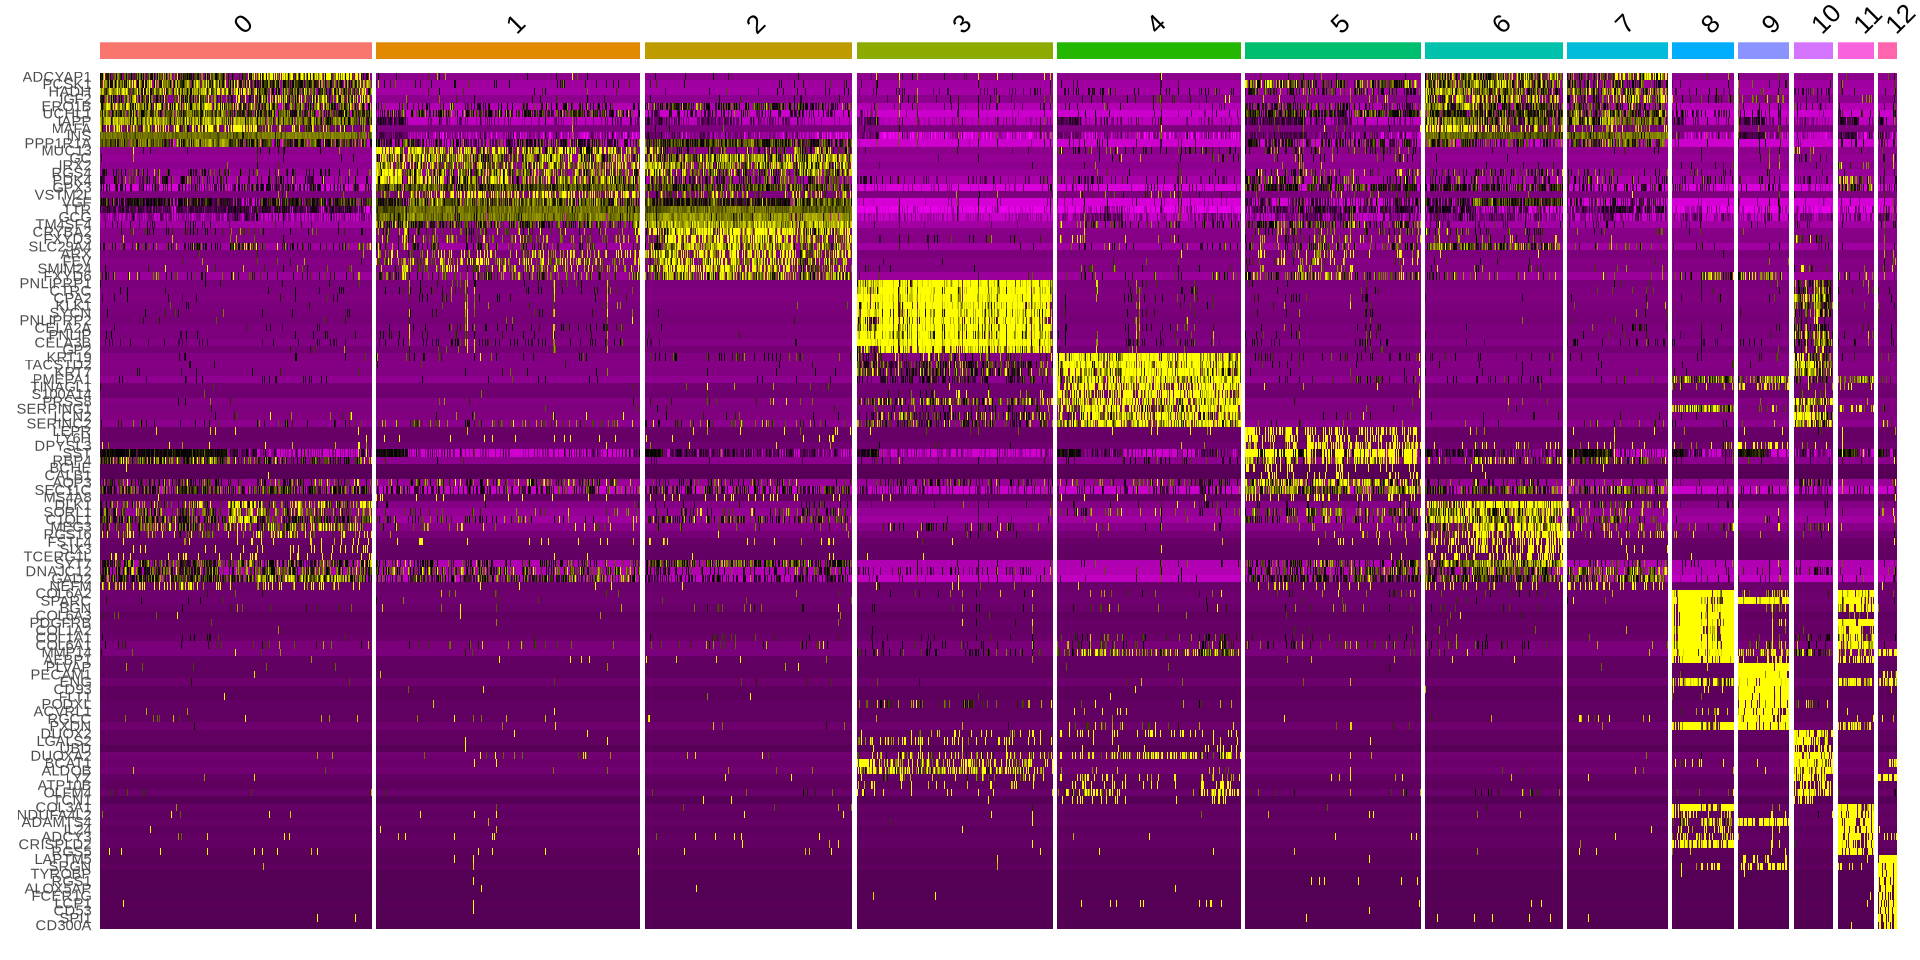

In [93]:
so2.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10_2
DoHeatmap(so2, features = top10_2$gene) + NoLegend()